
# BCG DATA SCIENCE AND ADVANCED ANALYTICS
## Task 3: Feature Engineering & Modelling
### Wendy Maria D’sa

---

1. Import packages
2. Load data
3. Feature engineering

---

<div class="alert alert-block alert-info">
    <b>
        FEATURE ENGINEERING:<br>
        1. Two more features were built over the feature of 'price difference between First month and Last month for each customer'. These were 'price difference between Last month and previous 3 months' and 'price difference between last month and previous 6 months'. Since, utility bills are usually quarterly it made sense to understand whether the prices increased or decreased from the start to the end.<br><br>
        CORRELATION MATRIX & DISTRIBUTION OF THE DATA:<br>
        1. The target variable 'churn' shows a weak to no correlation to all of the variables.<br>
        2. Statistical analysis, skewness, and kurtosis of the data shows that almost all the numerical variables are right skewed with many extreme outliers on the right.<br><br>
        MODELS:<br>
        1.Models built using the entire dataset shows good accuracy on both the training and test data, but shows very poor performance on other metrics (recall and precision) especially on the minority class.<br>
        2. The best performing model is Random Forest with combined under and over sampling. 'Accuracy' = 90% on test data, 21% 'Recall rate', 41% Precision, and 69% 'ROC-AUC'.<br>
        3. The improve the model the top and bottom 1% of data was trimmed. This drastically improved the prediction power of the models especially on the metrics of recall and precision. This also indicates that the bottom 0 values(missing/incomplete data are a major issue and should be rectified).<br>
        4. The best performing model here is also Random Forest with combined under and over sampling.<br>
        5. The evaluation metric chosen are 'Accuracy', 'Recall', and 'ROC-AUC'.<br>
            -'Accuracy' is a ratio of correctly predicted observation to the total observations. The model has a 98% test accuracy.<br>
            -'Recall' is a ratio of correctly predicted positive observations to the total predicted positive observations. The model has a 82% recall rate.<br>
            -'ROC' is a probability curve and 'AUC' represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. The model has a 96% 'ROC-AUC'.<br>
        6. These metrics were chosen because 'False positives'(FP) & 'False negatives'(FN) are an issue. If more FP's then you would be spending money where not required. If more FN's then you would be losing customers.<br>
        7. The fact that the prediction accuracies is about the same in both test and train data is a good sign that the models are working very well.<br>
        8. The weakness of this model is that 'forecast_cons_year' seems to be the most important feature with 75% weightage. This indicates that we would need more granularity with the other features in order to improve their perfomances. Another reason for this could be the skewness of the data. It may be worthwhile to perform transformations on the client dataset.
        9. Incidently, the imbalanced Logistic Regression and the imbalanced Random Forest models also perform nearly as well. These could be very helpful for deployment in low resource environments.<br><br>
        FINANCIAL ANALYSIS:<br>
        1. The threshold of 50% and above was considered as high probability to churn.<br>
        2. The average probability to churn in this set is 98%.<br>
        3. This average didn't change when the discounted price was computed into the data.<br>
        4. Taking the threshold of 0.5 probability to churn of test data, the revenue earned if the 20% discount is ~ 28% more than if there was no intervention.<br>
        NOTE: This has been calculated on the entire dataset using test data probabilities.<br>
        5. Overall, PowerCo would do well with the 20% discounting strategy assuming that all who are offered a discount will not churn. This may not be the case as price sensitivity features are scattered but are not the top main drivers for a customer churning.<br><br>
        FUTURE WORK:<br>
        1. Replace 0 values in the pricing dataset - the 0 could be either missing values or the companies could be on a single-tariff plan. In this case replace the 0 values with the off-peak values.<br>
        2. Perform further feature engineering on the client data. The number of years with the company gives an indication of when customers churn - perform feature engineering with the datetime data.<br>
        3. Look at the correlation matrix to drop some features that have high correlation to each other.<br>
        4. Perform log/boxcox/sqrt/yeo-johnson transformations on the skewed features.<br>
        5. Perform financial analysis with outputs of churn model using a sample test set.<br>
        6. Change the level of discount offered to find the optimal discount that will increase Net Margins.<br>
    </b>
</div>

## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy import stats
import statsmodels.graphics.gofplots as sm
import math
from datetime import datetime
import re

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# set plot style
plt.style.use('fivethirtyeight') #ggplot #fivethirtyeight #seaborn-dark

font = {'family' : 'Georgia',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

# view all columns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200000)

---
## 2. Load data

In [2]:
# Load dataframe
cleaned = 'clean_data_after_eda.csv'
price = 'price_data.csv'

cleaned_df = pd.read_csv(cleaned)
price_df = pd.read_csv(price)

In [3]:
# View sample
cleaned_df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,14287.0,54946.0,2212.0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,1149.83,1395.5,0.0,1.78,0.114481,0.098142,40.606701,t,159.96,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.124787,0.100749,0.06653,40.942265,22.35201,14.90134,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,foosdfpfkusacimwkcsosbicdxkicaua,4660.0,0.0,2212.0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,1395.5,0.0,16.27,0.145711,0.098837,44.311378,f,159.96,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.149609,0.007124,0.00000,44.311375,0.00000,0.00000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544.0,0.0,2212.0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,1395.5,0.0,38.72,0.165794,0.087899,44.311378,f,159.96,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.170512,0.088421,0.00000,44.385450,0.00000,0.00000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0


In [4]:
cleaned_df = cleaned_df.drop('Unnamed: 0', axis=1)
cleaned_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,14287.0,54946.0,2212.0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,1149.83,1395.5,0.0,1.78,0.114481,0.098142,40.606701,t,159.96,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.124787,0.100749,0.06653,40.942265,22.35201,14.90134,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,d29c2c54acc38ff3c0614d0a653813dd,foosdfpfkusacimwkcsosbicdxkicaua,4660.0,0.0,2212.0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,1395.5,0.0,16.27,0.145711,0.098837,44.311378,f,159.96,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.149609,0.007124,0.00000,44.311375,0.00000,0.00000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544.0,0.0,2212.0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,1395.5,0.0,38.72,0.165794,0.087899,44.311378,f,159.96,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.170512,0.088421,0.00000,44.385450,0.00000,0.00000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0


In [5]:
cleaned_df.shape

(14592, 53)

In [6]:
price_df.head(3)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0


In [7]:
price_df.shape

(193002, 8)

In [8]:
price_df.price_date.value_counts()

2015-08-01    16094
2015-12-01    16094
2015-07-01    16090
2015-11-01    16087
2015-06-01    16085
2015-10-01    16085
2015-02-01    16082
2015-09-01    16082
2015-05-01    16080
2015-04-01    16079
2015-03-01    16074
2015-01-01    16070
Name: price_date, dtype: int64

In [9]:
#View structure
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14592 entries, 0 to 14591
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14592 non-null  object 
 1   channel_sales                   14592 non-null  object 
 2   cons_12m                        14592 non-null  float64
 3   cons_gas_12m                    14592 non-null  float64
 4   cons_last_month                 14592 non-null  float64
 5   date_activ                      14592 non-null  object 
 6   date_end                        14592 non-null  object 
 7   date_modif_prod                 14592 non-null  object 
 8   date_renewal                    14592 non-null  object 
 9   forecast_cons_12m               14592 non-null  float64
 10  forecast_cons_year              14592 non-null  float64
 11  forecast_discount_energy        14592 non-null  float64
 12  forecast_meter_rent_12m         

In [10]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


In [11]:
# Convert to categories
cleaned_df[['channel_sales', 'has_gas', 'origin_up']] = cleaned_df[['channel_sales', 'has_gas', 'origin_up']].astype('category')

# Convert date to datetime
cleaned_df[['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']] = cleaned_df[['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']].astype('datetime64[ns]')
price_df[['price_date']] = price_df[['price_date']].astype('datetime64[ns]')

In [12]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14592 entries, 0 to 14591
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14592 non-null  object        
 1   channel_sales                   14592 non-null  category      
 2   cons_12m                        14592 non-null  float64       
 3   cons_gas_12m                    14592 non-null  float64       
 4   cons_last_month                 14592 non-null  float64       
 5   date_activ                      14592 non-null  datetime64[ns]
 6   date_end                        14592 non-null  datetime64[ns]
 7   date_modif_prod                 14592 non-null  datetime64[ns]
 8   date_renewal                    14592 non-null  datetime64[ns]
 9   forecast_cons_12m               14592 non-null  float64       
 10  forecast_cons_year              14592 non-null  float64       
 11  fo

In [13]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB


---

## 3. Feature engineering

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

<div class="alert alert-block alert-info">
    <b>
        NOTE:<br>
        <li>The calculation below is not the difference between December and the preceding January, but rather the difference between the first month and last month provided in the dataframe for each customer. As we can see below the value-counts for each month are different. This indicates that not all customers have observations starting from January or ending in December.</li><br>
        FEATURE ENGINEERING:<br>
        <li>In addition to the 27 mean price variables engineered in Task 2, 3 additional 'difference in price' features were engineered -</li>
        1. Difference between off-peak prices in First and Last month in 2015.<br>
        2. Difference between off-peak prices in 6 months preceeding and Last month in 2015.<br>
        3. Difference between off-peak prices in 3 months preceeding and Last month in 2015.<br>  
    </b>
</div>

In [14]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()
monthly_price_by_id.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,40.565969
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,40.728885
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,40.728885
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,40.728885


In [15]:
monthly_price_by_id.shape

(193002, 4)

In [16]:
monthly_price_by_id.price_date.value_counts()

2015-08-01    16094
2015-12-01    16094
2015-07-01    16090
2015-11-01    16087
2015-06-01    16085
2015-10-01    16085
2015-02-01    16082
2015-09-01    16082
2015-05-01    16080
2015-04-01    16079
2015-03-01    16074
2015-01-01    16070
Name: price_date, dtype: int64

### A. Difference between off-peak prices in First and Last month in 2015

In [17]:
# Get first and last month prices (yearly)
prices_first = monthly_price_by_id.groupby('id').first().reset_index()
prices_last = monthly_price_by_id.groupby('id').last().reset_index()

In [18]:
prices_first.head(3)

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0004351ebdd665e6ee664792efc4fd13,2015-01-01,0.148047,44.266931
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-01-01,0.150837,44.444710


In [19]:
prices_first.price_date.value_counts()

2015-01-01    16070
2015-02-01       15
2015-04-01        4
2015-06-01        3
2015-05-01        3
2015-03-01        1
Name: price_date, dtype: int64

In [20]:
prices_last.head(3)

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-12-01,0.119906,40.728885
1,0004351ebdd665e6ee664792efc4fd13,2015-12-01,0.143943,44.444710
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-12-01,0.201280,45.944710


In [21]:
prices_last.price_date.value_counts()

2015-12-01    16094
2015-10-01        1
2015-11-01        1
Name: price_date, dtype: int64

In [22]:
# Calculate the difference
diff = pd.merge(prices_last.rename(columns={'price_off_peak_var': 'last_1', 'price_off_peak_fix': 'last_2'}), prices_first.drop(columns='price_date'), on='id')
diff['offpeak_diff_first_last_energy'] = diff['last_1'] - diff['price_off_peak_var']
diff['offpeak_diff_first_last_power'] = diff['last_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_first_last_energy','offpeak_diff_first_last_power']]
diff.head(3)

,id,offpeak_diff_first_last_energy,offpeak_diff_first_last_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000


In [23]:
diff.shape

(16096, 3)

### B. Difference between off-peak prices in Last and 3 months preceeding 2015 (last 3 months)

In [24]:
# Get last and 3 months preceeding prices (last 3 months)
prices_3m = monthly_price_by_id.groupby('id').nth(-3).reset_index()

In [25]:
prices_3m.head(3)

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-10-01,0.119906,40.728885
1,0004351ebdd665e6ee664792efc4fd13,2015-10-01,0.143943,44.444710
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-10-01,0.201280,45.944710


In [26]:
prices_3m.price_date.value_counts()

2015-10-01    16075
2015-09-01       20
2015-08-01        1
Name: price_date, dtype: int64

In [27]:
# Calculate the difference
diff_3m = pd.merge(prices_last.rename(columns={'price_off_peak_var': 'last_1', 'price_off_peak_fix': 'last_2'}), prices_3m.drop(columns='price_date'), on='id')
diff_3m['offpeak_diff_3m_last_energy'] = diff_3m['last_1'] - diff_3m['price_off_peak_var']
diff_3m['offpeak_diff_3m_last_power'] = diff_3m['last_2'] - diff_3m['price_off_peak_fix']
diff_3m = diff_3m[['id', 'offpeak_diff_3m_last_energy','offpeak_diff_3m_last_power']]
diff_3m.head(3)

,id,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power
0,0002203ffbb812588b632b9e628cc38d,0.0,0.0
1,0004351ebdd665e6ee664792efc4fd13,0.0,0.0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.0,0.0


In [28]:
diff_3m.shape

(16096, 3)

### C. Difference between off-peak prices in Last and 6 months preceeding 2015 (last 6 months)

In [29]:
# Get last and 6 months preceeding prices (last 6 months)
prices_6m = monthly_price_by_id.groupby('id').nth(-6).reset_index()

In [30]:
prices_6m.head(3)

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-07-01,0.128067,40.728885
1,0004351ebdd665e6ee664792efc4fd13,2015-07-01,0.148405,44.444710
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-07-01,0.205742,45.944710


In [31]:
prices_6m.price_date.value_counts()

2015-07-01    16056
2015-06-01       35
2015-05-01        4
2015-04-01        1
Name: price_date, dtype: int64

In [32]:
# Calculate the difference
diff_6m = pd.merge(prices_last.rename(columns={'price_off_peak_var': 'last_1', 'price_off_peak_fix': 'last_2'}), prices_6m.drop(columns='price_date'), on='id')
diff_6m['offpeak_diff_6m_last_energy'] = diff_6m['last_1'] - diff_6m['price_off_peak_var']
diff_6m['offpeak_diff_6m_last_power'] = diff_6m['last_2'] - diff_6m['price_off_peak_fix']
diff_6m = diff_6m[['id', 'offpeak_diff_6m_last_energy','offpeak_diff_6m_last_power']]
diff_6m.head(3)

,id,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power
0,0002203ffbb812588b632b9e628cc38d,-0.008161,0.0
1,0004351ebdd665e6ee664792efc4fd13,-0.004462,0.0
2,0010bcc39e42b3c2131ed2ce55246e3c,-0.004462,0.0


In [33]:
diff_6m.shape

(16096, 3)

In [34]:
# Merge all 3 datasets
diff_prices = pd.merge(diff, diff_6m, on='id')
diff_prices = pd.merge(diff_prices, diff_3m, on='id')

diff_prices.head()

,id,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,-0.008161,0.0,0.0,0.0
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,-0.004462,0.0,0.0,0.0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000,-0.004462,0.0,0.0,0.0
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916,-0.008161,0.0,0.0,0.0
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001,-0.004462,0.0,0.0,0.0


In [35]:
diff_prices.shape

(16096, 7)

In [36]:
# Merge with cleaned client dataframe
feat_data = pd.merge(cleaned_df, diff_prices, on='id')
feat_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,14287.0,54946.0,2212.0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,1149.83,1395.5,0.0,1.78,0.114481,0.098142,40.606701,t,159.96,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961,0.020393,3.538045,0.028554,3.538045
1,d29c2c54acc38ff3c0614d0a653813dd,foosdfpfkusacimwkcsosbicdxkicaua,4660.0,0.0,2212.0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,1395.5,0.0,16.27,0.145711,0.098837,44.311378,f,159.96,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779,-0.003767,0.177780,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544.0,0.0,2212.0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,1395.5,0.0,38.72,0.165794,0.087899,44.311378,f,159.96,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779,-0.004628,0.000000,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584.0,0.0,2212.0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,1395.5,0.0,19.83,0.146694,0.098837,44.311378,f,159.96,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779,-0.004462,0.000000,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,foosdfpfkusacimwkcsosbicdxkicaua,4425.0,0.0,526.0,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526.0,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.121266,0.102368,0.073728,40.728885,24.437330,16.291555,40.850151,24.539698,16.365283,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916,-0.008161,0.000000,0.000000,0.000000


In [37]:
feat_data.shape

(14592, 59)

---

## 4. Data Evaluation

<div class="alert alert-block alert-info">
    <b>
        CORRELATION MATRIX:<br>
        1. The target variable 'churn' shows a weak to no correlation to all of the variables.<br>
        2. Most of the 27 mean price features show a strong to medium correlations to each other., while all of the 3 new 'difference in price' features show medium positive correlations to each other.<br><br>
        DISTRIBUTION OF THE DATA:<br>
        1. Statistical analysis, skewness, and kurtosis of the data shows that almost all the numerical variables are right skewed with many extreme outliers on the right.<br>
        2. All the features also have different scales. Thus, there is a chance that higher weightage will be given to features with higher magnitude and cause biases. We will need to use a Feature scaling method - such as Standardisation - this will ensure that all features contribute equally to the result.<br>
        NOTE: Decision tree based algorithms such as Random Forest are fairly insensitive to the scale of the features. But, we will go ahead with scaling so that we can also train the model on non tree based algorithms.<br>
    </b>
</div>

### A. Check whether original cleaned data has any negative values and null values

In [38]:
# create only numerical dataframe
num_data = cleaned_df.select_dtypes(include='number')

In [39]:
# check data for negative values
(num_data < 0).any().any()

False

In [40]:
# check null values
feat_data.isnull().sum()

id                                0
channel_sales                     0
cons_12m                          0
cons_gas_12m                      0
cons_last_month                   0
date_activ                        0
date_end                          0
date_modif_prod                   0
date_renewal                      0
forecast_cons_12m                 0
forecast_cons_year                0
forecast_discount_energy          0
forecast_meter_rent_12m           0
forecast_price_energy_off_peak    0
forecast_price_energy_peak        0
forecast_price_pow_off_peak       0
has_gas                           0
imp_cons                          0
margin_gross_pow_ele              0
margin_net_pow_ele                0
nb_prod_act                       0
net_margin                        0
num_years_antig                   0
origin_up                         0
pow_max                           0
mean_year_price_p1_var            0
mean_year_price_p2_var            0
mean_year_price_p3_var      

### B. Check correlations

In [41]:
# Correlation function
def correlation_heatmap(dataframe, size_=(20,20), annot_=False):
    
    # Set the style of the visualization
    sns.set(style="white")
    
    plt.style.use('fivethirtyeight') #ggplot #fivethirtyeight #seaborn-dark
    font = {'family' : 'Georgia',
        'weight' : 'normal',
        'size'   : 12}
    
    matplotlib.rc('font', **font)
    
    # Create a covariance matrix
    corr = dataframe.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_)

    # Generate a custom diverging colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("n",['#fc4f30','#ffffff','#30a2da'])
    
    mask = np.triu(np.ones_like(dataframe.corr(), dtype=np.bool))
    
    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, mask=mask, cbar_kws={"shrink": .5}, vmin=-1, vmax=1, annot = annot_)
    ax.set_title('Correlation Matrix', fontsize=17, fontweight='bold')
    plt.show()

C:\Users\Wendy\AppData\Local\Temp/ipykernel_20568/2274976762.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(dataframe.corr(), dtype=np.bool))


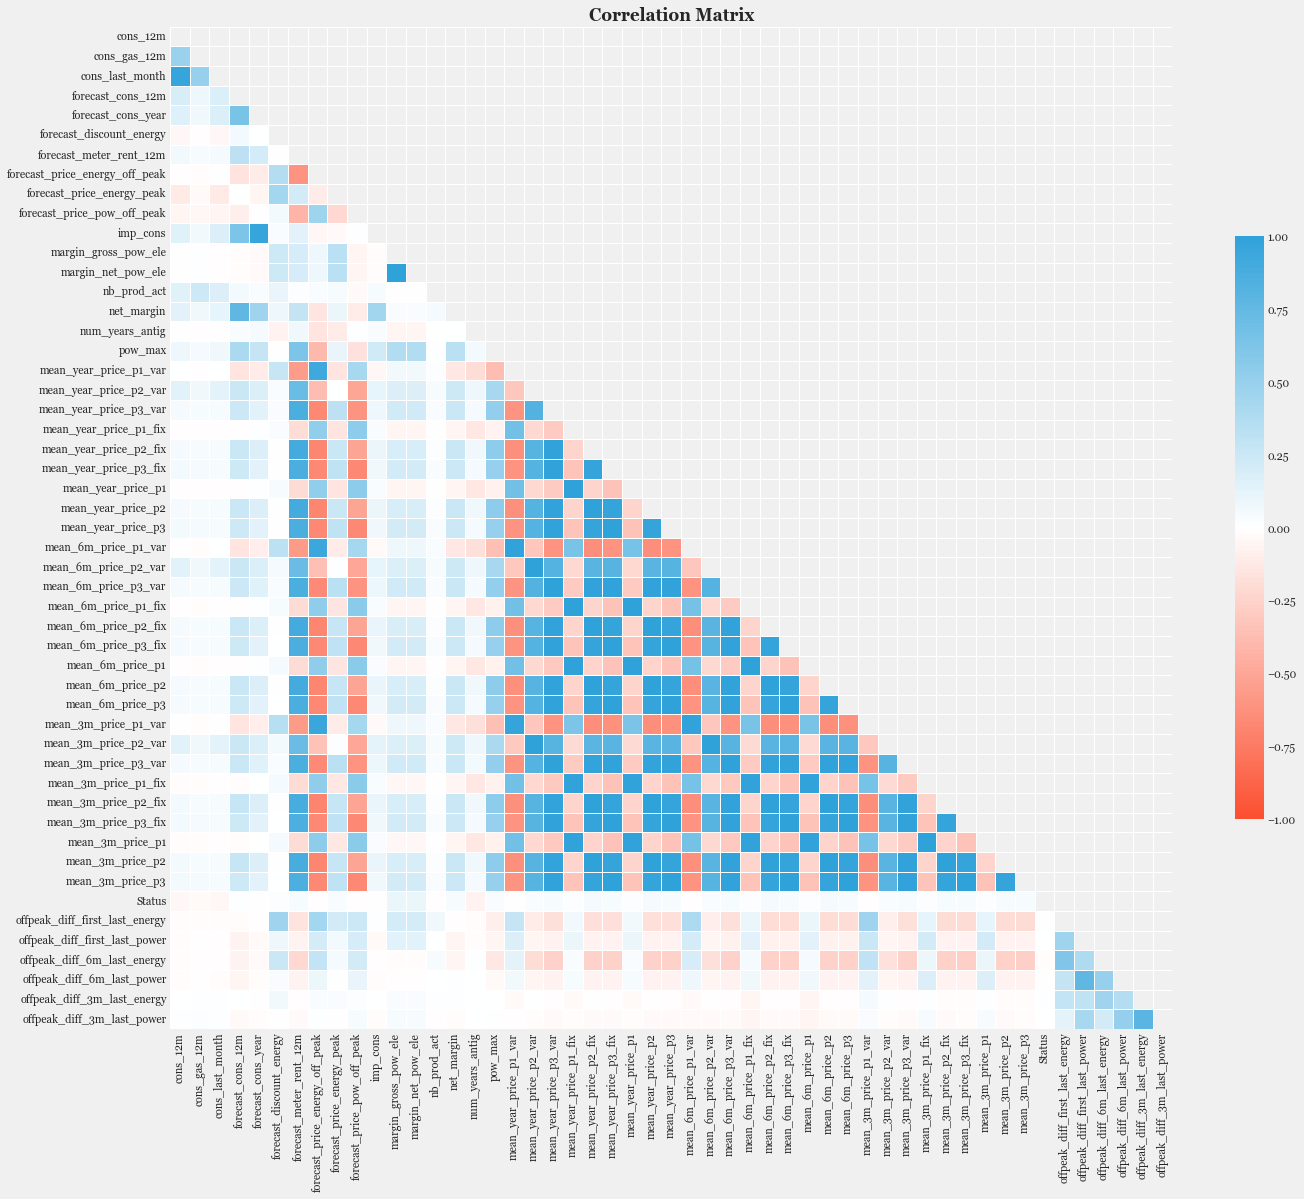

In [42]:
correlation_heatmap(feat_data)

### C. Distribution of data

In [43]:
# Statistical analysis
feat_data.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14592.0,159473.951343,573692.313775,1.000000,5836.000000,14287.000000,40783.000000,6.207104e+06
cons_gas_12m,14592.0,28243.667763,163034.950451,0.000000,0.000000,0.000000,0.000000,4.154590e+06
cons_last_month,14592.0,16858.957511,64213.005238,1.000000,1395.000000,2212.000000,3385.250000,7.712030e+05
forecast_cons_12m,14592.0,1893.391393,2375.393079,0.100000,535.540000,1149.830000,2403.647500,8.290283e+04
forecast_cons_year,14592.0,1987.728481,3063.811274,1.000000,1122.000000,1395.500000,1747.250000,1.753750e+05
forecast_discount_energy,14592.0,0.967311,5.110548,0.000000,0.000000,0.000000,0.000000,3.000000e+01
forecast_meter_rent_12m,14592.0,63.972506,65.314418,0.090000,16.370000,19.430000,131.020000,5.993100e+02
forecast_price_energy_off_peak,14592.0,0.137537,0.024013,0.000600,0.116340,0.143166,0.146348,2.739630e-01
forecast_price_energy_peak,14592.0,0.098012,0.006725,0.076592,0.098837,0.098837,0.098837,1.959750e-01
forecast_price_pow_off_peak,14592.0,43.401241,2.804546,35.555768,40.606701,44.311378,44.311378,5.926638e+01


In [44]:
feat_data.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
cons_12m,5.994670,42.650651
cons_gas_12m,9.593055,126.225683
cons_last_month,6.408852,47.983540
forecast_cons_12m,7.251811,150.371617
forecast_cons_year,19.235512,812.047118
forecast_discount_energy,5.152833,24.829785
forecast_meter_rent_12m,1.545202,4.730796
forecast_price_energy_off_peak,0.126729,7.948299
forecast_price_energy_peak,2.649920,23.745940
forecast_price_pow_off_peak,2.500078,12.662255


### D. Prepare data

In [45]:
feat_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,14287.0,54946.0,2212.0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,1149.83,1395.5,0.0,1.78,0.114481,0.098142,40.606701,t,159.96,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961,0.020393,3.538045,0.028554,3.538045
1,d29c2c54acc38ff3c0614d0a653813dd,foosdfpfkusacimwkcsosbicdxkicaua,4660.0,0.0,2212.0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,1395.5,0.0,16.27,0.145711,0.098837,44.311378,f,159.96,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779,-0.003767,0.177780,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544.0,0.0,2212.0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,1395.5,0.0,38.72,0.165794,0.087899,44.311378,f,159.96,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779,-0.004628,0.000000,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584.0,0.0,2212.0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,1395.5,0.0,19.83,0.146694,0.098837,44.311378,f,159.96,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779,-0.004462,0.000000,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,foosdfpfkusacimwkcsosbicdxkicaua,4425.0,0.0,526.0,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526.0,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.121266,0.102368,0.073728,40.728885,24.437330,16.291555,40.850151,24.539698,16.365283,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916,-0.008161,0.000000,0.000000,0.000000


In [46]:
# Abbr. channel sales values
feat_data.channel_sales = feat_data.channel_sales.str[0:5]
abbr_channel_sales = {'foosd': 'SC_A', 'lmkeb': 'SC_B', 'usilx': 'SC_C', 'ewpak': 'SC_D', 'sddie': 'SC_E', 'epumf': 'SC_F', 'fixdb': 'SC_G'}
feat_data.channel_sales = feat_data.channel_sales.map(abbr_channel_sales)

# Abbr. origin up values
feat_data.origin_up = feat_data.origin_up.str[0:5]
abbr_electricity_campaign = {'lxidp': 'EC_A', 'kamkk': 'EC_B', 'ldkss': 'EC_C', 'usapb': 'EC_D', 'ewxee': 'EC_E'}
feat_data.origin_up = feat_data.origin_up.map(abbr_electricity_campaign)

# Abbr. has gas values
feat_data.has_gas.replace({'t': 0, 'f': 1}, inplace=True)

feat_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power
0,24011ae4ebbe3035111d65fa7c15bc57,SC_A,14287.0,54946.0,2212.0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,1149.83,1395.5,0.0,1.78,0.114481,0.098142,40.606701,0,159.96,25.44,25.44,2,678.99,3,EC_A,43.648,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961,0.020393,3.538045,0.028554,3.538045
1,d29c2c54acc38ff3c0614d0a653813dd,SC_A,4660.0,0.0,2212.0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,1395.5,0.0,16.27,0.145711,0.098837,44.311378,1,159.96,16.38,16.38,1,18.89,6,EC_B,13.800,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779,-0.003767,0.177780,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,SC_A,544.0,0.0,2212.0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,1395.5,0.0,38.72,0.165794,0.087899,44.311378,1,159.96,28.60,28.60,1,6.60,6,EC_B,13.856,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779,-0.004628,0.000000,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,SC_B,1584.0,0.0,2212.0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,1395.5,0.0,19.83,0.146694,0.098837,44.311378,1,159.96,30.22,30.22,1,25.46,6,EC_B,13.200,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779,-0.004462,0.000000,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,SC_A,4425.0,0.0,526.0,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526.0,0.0,131.73,0.116900,0.100015,40.606701,1,52.32,44.91,44.91,1,47.98,6,EC_B,19.800,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.121266,0.102368,0.073728,40.728885,24.437330,16.291555,40.850151,24.539698,16.365283,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916,-0.008161,0.000000,0.000000,0.000000


In [47]:
# Subset categorical data
cat_data = feat_data[['id', 'channel_sales', 'origin_up']]
cat_data.head()

,id,channel_sales,origin_up
0,24011ae4ebbe3035111d65fa7c15bc57,SC_A,EC_A
1,d29c2c54acc38ff3c0614d0a653813dd,SC_A,EC_B
2,764c75f661154dac3a6c254cd082ea7d,SC_A,EC_B
3,bba03439a292a1e166f80264c16191cb,SC_B,EC_B
4,149d57cf92fc41cf94415803a877cb4b,SC_A,EC_B


In [48]:
# One hot encode categorical variables
# generate values using get_dummies
dum_df = pd.get_dummies(cat_data, columns=['channel_sales', 'origin_up'], prefix='', prefix_sep='')

cat_data = pd.merge(cat_data.drop(columns=['channel_sales', 'origin_up']) , dum_df, on='id')
cat_data.head()

,id,SC_A,SC_B,SC_C,SC_D,SC_E,SC_F,SC_G,EC_A,EC_B,EC_C,EC_D,EC_E
0,24011ae4ebbe3035111d65fa7c15bc57,1,0,0,0,0,0,0,1,0,0,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,1,0,0,0,0,0,0,0,1,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,1,0,0,0,0,0,0,0,1,0,0,0
3,bba03439a292a1e166f80264c16191cb,0,1,0,0,0,0,0,0,1,0,0,0
4,149d57cf92fc41cf94415803a877cb4b,1,0,0,0,0,0,0,0,1,0,0,0


In [49]:
# merge with main dataframe
feat_data = pd.merge(feat_data.drop(columns=['channel_sales', 'origin_up']), cat_data, on='id')
feat_data.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power,SC_A,SC_B,SC_C,SC_D,SC_E,SC_F,SC_G,EC_A,EC_B,EC_C,EC_D,EC_E
0,24011ae4ebbe3035111d65fa7c15bc57,14287.0,54946.0,2212.0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,1149.83,1395.5,0.0,1.78,0.114481,0.098142,40.606701,0,159.96,25.44,25.44,2,678.99,3,43.648,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961,0.020393,3.538045,0.028554,3.538045,1,0,0,0,0,0,0,1,0,0,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660.0,0.0,2212.0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,1395.5,0.0,16.27,0.145711,0.098837,44.311378,1,159.96,16.38,16.38,1,18.89,6,13.800,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779,-0.003767,0.177780,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544.0,0.0,2212.0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,1395.5,0.0,38.72,0.165794,0.087899,44.311378,1,159.96,28.60,28.60,1,6.60,6,13.856,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779,-0.004628,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0
3,bba03439a292a1e166f80264c16191cb,1584.0,0.0,2212.0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,1395.5,0.0,19.83,0.146694,0.098837,44.311378,1,159.96,30.22,30.22,1,25.46,6,13.200,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779,-0.004462,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,1,0,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425.0,0.0,526.0,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526.0,0.0,131.73,0.116900,0.100015,40.606701,1,52.32,44.91,44.91,1,47.98,6,19.800,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.121266,0.102368,0.073728,40.728885,24.437330,16.291555,40.850151,24.539698,16.365283,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916,-0.008161,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0


In [50]:
# Drop unwanted columns
data = feat_data.drop(['id', 'date_activ', 'date_end','date_modif_prod', 'date_renewal'], axis=1)
data.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power,SC_A,SC_B,SC_C,SC_D,SC_E,SC_F,SC_G,EC_A,EC_B,EC_C,EC_D,EC_E
0,14287.0,54946.0,2212.0,1149.83,1395.5,0.0,1.78,0.114481,0.098142,40.606701,0,159.96,25.44,25.44,2,678.99,3,43.648,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961,0.020393,3.538045,0.028554,3.538045,1,0,0,0,0,0,0,1,0,0,0,0
1,4660.0,0.0,2212.0,189.95,1395.5,0.0,16.27,0.145711,0.098837,44.311378,1,159.96,16.38,16.38,1,18.89,6,13.800,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779,-0.003767,0.177780,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0
2,544.0,0.0,2212.0,47.96,1395.5,0.0,38.72,0.165794,0.087899,44.311378,1,159.96,28.60,28.60,1,6.60,6,13.856,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779,-0.004628,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0
3,1584.0,0.0,2212.0,240.04,1395.5,0.0,19.83,0.146694,0.098837,44.311378,1,159.96,30.22,30.22,1,25.46,6,13.200,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779,-0.004462,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,1,0,0,0
4,4425.0,0.0,526.0,445.75,526.0,0.0,131.73,0.116900,0.100015,40.606701,1,52.32,44.91,44.91,1,47.98,6,19.800,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.121266,0.102368,0.073728,40.728885,24.437330,16.291555,40.850151,24.539698,16.365283,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916,-0.008161,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0


In [51]:
data.shape

(14592, 64)

---

## 5. Model Building with entire dataset

<div class="alert alert-block alert-info">
    <b>
        Logistic Regression and Random Forest models and its variants were used to predict churn.<br>
        <li>Although our models show great accuracy, all other measures are very low especially on the minority class.</li>
        <li>We will be using the accuracy and recall metrics as our evaluation metrics.</li>
        <li>The fact that the prediction accuracies is about the same in both test and train data is a good sign that the models are working well.</li>
        <li>The best model here is the Random Forest model with combined under and oversampling with the best accuracy as well as the best recall rate.</li><br>
        
| Model | Train Accuracy | Test Accuracy | Recall | Precision | F1 score | ROC-AUC | 
| --- | --- | --- | --- | --- | --- | --- |
|Imbalanced Logistic Regression| 0.90 | 0.90 | 0.01 | 0.33 | 0.01 | 0.66 |
|Logistic Regression balanced class weights| 0.63 | 0.63 | 0.59 | 0.15 | 0.24 | 0.66 |
|Imbalanced Random Forest| 0.91 | 0.91 | 0.08 | 0.61 | 0.14 | 0.68 |
|Random Forest balanced class weight| 0.91 | 0.91 | 0.07 | 0.83 | 0.13 | 0.70 |
|Random Forest Random undersampling| 0.65 | 0.67 | 0.63 | 0.17 | 0.27 | 0.70 |
|Random Forest hybrid under and oversampling| 0.95 | 0.90 | 0.21 | 0.47 | 0.29 | 0.69 |
   </b>
</div>

In [52]:
# Create train and test data
X = data.drop('Status', axis=1)
y = data['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 40, stratify= y)

In [53]:
# Dividing features
num_feat = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 
            'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
            'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
            'forecast_price_energy_peak', 'forecast_price_pow_off_peak',
            'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
            'net_margin', 'num_years_antig', 'pow_max',
            'mean_year_price_p1_var', 'mean_year_price_p2_var',
            'mean_year_price_p3_var', 'mean_year_price_p1_fix',
            'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
            'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3',
            'mean_6m_price_p1_var', 'mean_6m_price_p2_var', 'mean_6m_price_p3_var',
            'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix', 'mean_6m_price_p3_fix',
            'mean_6m_price_p1', 'mean_6m_price_p2', 'mean_6m_price_p3',
            'mean_3m_price_p1_var', 'mean_3m_price_p2_var', 'mean_3m_price_p3_var',
            'mean_3m_price_p1_fix', 'mean_3m_price_p2_fix', 'mean_3m_price_p3_fix',
            'mean_3m_price_p1', 'mean_3m_price_p2', 'mean_3m_price_p3', 
            'offpeak_diff_first_last_energy', 'offpeak_diff_first_last_power',
            'offpeak_diff_6m_last_energy', 'offpeak_diff_6m_last_power',
            'offpeak_diff_3m_last_energy', 'offpeak_diff_3m_last_power']

### A. Base Model Logistic Regression on imbalanced data

In [54]:
index = []
scores = {"Accuracy": []}

In [55]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model_lr = LogisticRegression(max_iter=1000, random_state=42)

# # Define transformerr
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe_lr = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_lr)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe_lr.fit(X_train, y_train)
score_lr = cross_val_score(pipe_lr, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Imbalanced Logistic Regression: Train"]
scores["Accuracy"].append(round(score_lr.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2635
           1       0.33      0.01      0.01       284

    accuracy                           0.90      2919
   macro avg       0.62      0.50      0.48      2919
weighted avg       0.85      0.90      0.86      2919



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


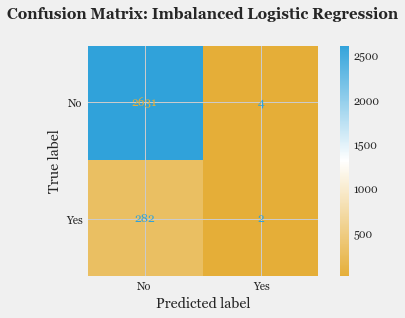

In [56]:
pred_lr = pipe_lr.predict(X_test)

ac = accuracy_score(y_test, pred_lr)
print(f'Accuracy: {ac:.2f}')

print(classification_report(y_test, pred_lr))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe_lr, X_test, y_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Imbalanced Logistic Regression', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [57]:
index += ["Imbalanced Logistic Regression: Test"]
scores["Accuracy"].append(round(accuracy_score(y_test, pred_lr), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902


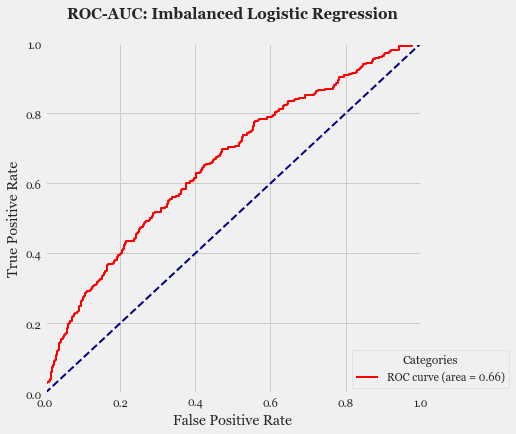

In [58]:
pred_prob_lr = pipe_lr.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test, pred_prob_lr)
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr_lr, tpr_lr, color='red', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Imbalanced Logistic Regression', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

### B. Logistic regression with balanced class weights

In [59]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model_lr1 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe_lr1 = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_lr1)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe_lr1.fit(X_train, y_train)
score_lr1 = cross_val_score(pipe_lr1, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Logistic Regression balanced class weights: Train"]
scores["Accuracy"].append(round(score_lr1.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902
Logistic Regression balanced class weights: Train,0.628


Accuracy_test: 0.63
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      2635
           1       0.15      0.59      0.24       284

    accuracy                           0.63      2919
   macro avg       0.54      0.62      0.50      2919
weighted avg       0.86      0.63      0.71      2919



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


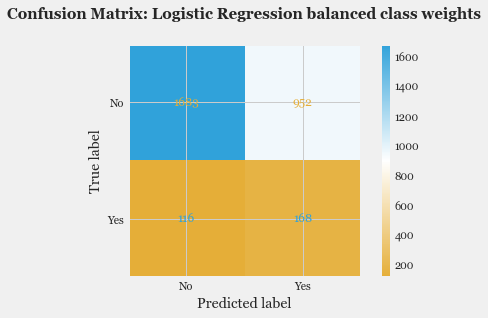

In [60]:
pred_lr1 = pipe_lr1.predict(X_test)

ac = accuracy_score(y_test, pred_lr1)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(y_test, pred_lr1))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe_lr1, X_test, y_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Logistic Regression balanced class weights', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [61]:
index += ["Logistic Regression balanced class weights: Test"]
scores["Accuracy"].append(round(accuracy_score(y_test, pred_lr1), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902
Logistic Regression balanced class weights: Train,0.628
Logistic Regression balanced class weights: Test,0.634


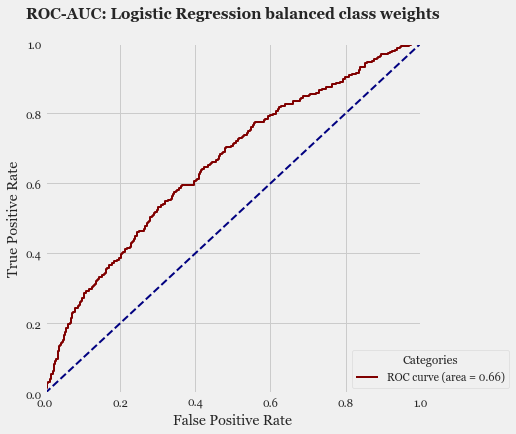

In [62]:
pred_prob_lr1 = pipe_lr1.predict_proba(X_test)[:,1]

fpr_lr1, tpr_lr1, _ = metrics.roc_curve(y_test, pred_prob_lr1)
roc_auc_lr1 = metrics.auc(fpr_lr1, tpr_lr1)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr_lr1, tpr_lr1, color='maroon', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc_lr1)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Logistic Regression balanced class weights', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

### C. Imbalanced Random Forest

In [63]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model_rf = RandomForestClassifier(max_features=None, random_state=42, n_jobs=2)

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe_rf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_rf)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe_rf.fit(X_train, y_train)
score_rf = cross_val_score(pipe_rf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Imbalanced Random Forest: Train"]
scores["Accuracy"].append(round(score_rf.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902
Logistic Regression balanced class weights: Train,0.628
Logistic Regression balanced class weights: Test,0.634
Imbalanced Random Forest: Train,0.905


Accuracy_test: 0.91
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2635
           1       0.61      0.08      0.14       284

    accuracy                           0.91      2919
   macro avg       0.76      0.54      0.54      2919
weighted avg       0.88      0.91      0.87      2919



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


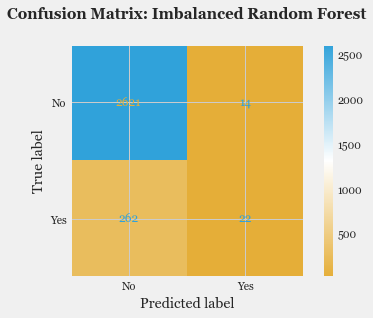

In [64]:
pred_rf = pipe_rf.predict(X_test)

ac = accuracy_score(y_test, pred_rf)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(y_test, pred_rf))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe_rf, X_test, y_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Imbalanced Random Forest', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [65]:
index += ["Imbalanced Random Forest: Test"]
scores["Accuracy"].append(round(accuracy_score(y_test, pred_rf), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902
Logistic Regression balanced class weights: Train,0.628
Logistic Regression balanced class weights: Test,0.634
Imbalanced Random Forest: Train,0.905
Imbalanced Random Forest: Test,0.905


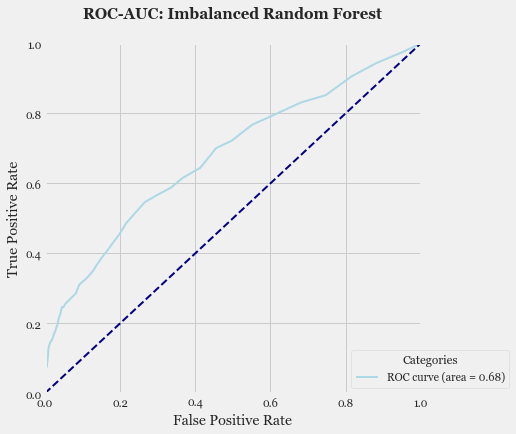

In [66]:
pred_prob_rf = pipe_rf.predict_proba(X_test)[:,1]

fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, pred_prob_rf)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr_rf, tpr_rf, color='lightblue', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Imbalanced Random Forest', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

### D. Random Forest with balanced class weight

In [67]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model_rf1 = RandomForestClassifier(max_features=None, random_state=42, n_jobs=2, class_weight='balanced')

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe_rf1 = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_rf1)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe_rf1.fit(X_train, y_train)
score_rf1 = cross_val_score(pipe_rf1, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Random Forest balanced class weight: Train"]
scores["Accuracy"].append(round(score_rf1.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902
Logistic Regression balanced class weights: Train,0.628
Logistic Regression balanced class weights: Test,0.634
Imbalanced Random Forest: Train,0.905
Imbalanced Random Forest: Test,0.905
Random Forest balanced class weight: Train,0.906


Accuracy_test: 0.91
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2635
           1       0.83      0.07      0.13       284

    accuracy                           0.91      2919
   macro avg       0.87      0.53      0.54      2919
weighted avg       0.90      0.91      0.87      2919



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


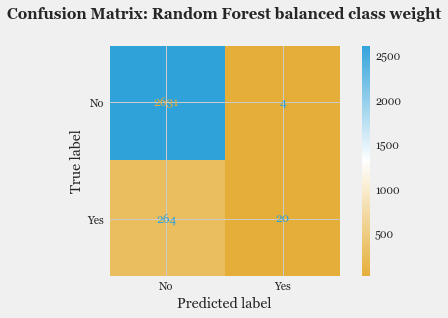

In [68]:
pred_rf1 = pipe_rf1.predict(X_test)

ac = accuracy_score(y_test, pred_rf1)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(y_test, pred_rf1))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe_rf1, X_test, y_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Random Forest balanced class weight', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [69]:
index += ["Random Forest balanced class weight_Test"]
scores["Accuracy"].append(round(accuracy_score(y_test, pred_rf1), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902
Logistic Regression balanced class weights: Train,0.628
Logistic Regression balanced class weights: Test,0.634
Imbalanced Random Forest: Train,0.905
Imbalanced Random Forest: Test,0.905
Random Forest balanced class weight: Train,0.906
Random Forest balanced class weight_Test,0.908


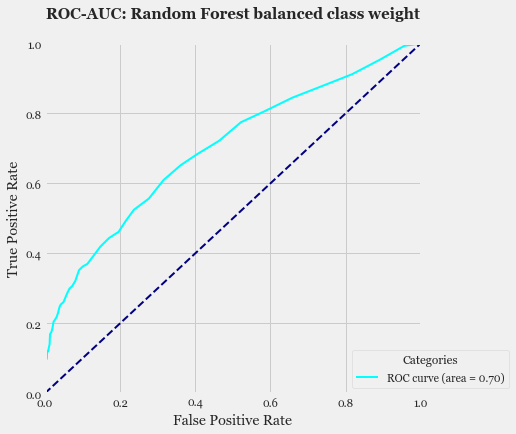

In [70]:
pred_prob_rf1 = pipe_rf1.predict_proba(X_test)[:,1]

fpr_rf1, tpr_rf1, _ = metrics.roc_curve(y_test, pred_prob_rf1)
roc_auc_rf1 = metrics.auc(fpr_rf1, tpr_rf1)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr_rf1, tpr_rf1, color='cyan', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc_rf1)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Random Forest balanced class weight', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

### E. Random Forest with Random undersampling

In [71]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model_rf2 = BalancedRandomForestClassifier(max_features=None, random_state=42, n_jobs=2)

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe_rf2 = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_rf2)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe_rf2.fit(X_train, y_train)
score_rf2 = cross_val_score(pipe_rf2, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Random Forest random undersampling: Train"]
scores["Accuracy"].append(round(score_rf2.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902
Logistic Regression balanced class weights: Train,0.628
Logistic Regression balanced class weights: Test,0.634
Imbalanced Random Forest: Train,0.905
Imbalanced Random Forest: Test,0.905
Random Forest balanced class weight: Train,0.906
Random Forest balanced class weight_Test,0.908
Random Forest random undersampling: Train,0.648


Accuracy_test: 0.67
              precision    recall  f1-score   support

           0       0.94      0.67      0.79      2635
           1       0.17      0.63      0.27       284

    accuracy                           0.67      2919
   macro avg       0.56      0.65      0.53      2919
weighted avg       0.87      0.67      0.74      2919



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


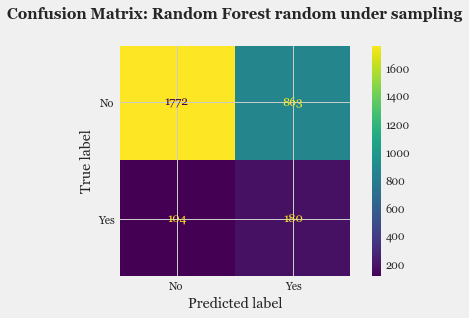

In [72]:
pred_rf2 = pipe_rf2.predict(X_test)

ac = accuracy_score(y_test, pred_rf2)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(y_test, pred_rf2))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe_rf2, X_test, y_test, display_labels=['No', 'Yes'])
plt.title('Confusion Matrix: Random Forest random under sampling', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [73]:
index += ["Random Forest random undersampling: Test"]
scores["Accuracy"].append(round(accuracy_score(y_test, pred_rf2), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902
Logistic Regression balanced class weights: Train,0.628
Logistic Regression balanced class weights: Test,0.634
Imbalanced Random Forest: Train,0.905
Imbalanced Random Forest: Test,0.905
Random Forest balanced class weight: Train,0.906
Random Forest balanced class weight_Test,0.908
Random Forest random undersampling: Train,0.648
Random Forest random undersampling: Test,0.669


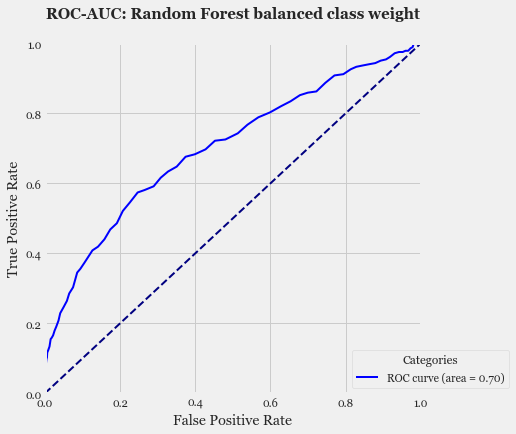

In [74]:
pred_prob_rf2 = pipe_rf2.predict_proba(X_test)[:,1]

fpr_rf2, tpr_rf2, _ = metrics.roc_curve(y_test, pred_prob_rf2)
roc_auc_rf2 = metrics.auc(fpr_rf2, tpr_rf2)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr_rf2, tpr_rf2, color='blue', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc_rf2)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Random Forest balanced class weight', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

### F. Random Forest with hybrid under and oversampling

In [75]:
print(Counter(y_train))

# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.3)
# fit and apply the transform
Xo, yo = over.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(y))

# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
Xtrain_rs, ytrain_rs = under.fit_resample(Xo, yo)
# summarize class distribution
print(Counter(ytrain_rs))

Counter({0: 10538, 1: 1135})
Counter({0: 13173, 1: 1419})
Counter({0: 6322, 1: 3161})


In [76]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model_rf3 = RandomForestClassifier(max_features=None, random_state=42, n_jobs=2)

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe_rf3 = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_rf3)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe_rf3.fit(Xtrain_rs, ytrain_rs)
score_rf3 = cross_val_score(pipe_rf3, Xtrain_rs, ytrain_rs, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Random Forest over & under sampling: Train"]
scores["Accuracy"].append(round(score_rf3.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902
Logistic Regression balanced class weights: Train,0.628
Logistic Regression balanced class weights: Test,0.634
Imbalanced Random Forest: Train,0.905
Imbalanced Random Forest: Test,0.905
Random Forest balanced class weight: Train,0.906
Random Forest balanced class weight_Test,0.908
Random Forest random undersampling: Train,0.648
Random Forest random undersampling: Test,0.669


Accuracy_test: 0.90
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2635
           1       0.42      0.20      0.27       284

    accuracy                           0.90      2919
   macro avg       0.67      0.59      0.61      2919
weighted avg       0.87      0.90      0.88      2919



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


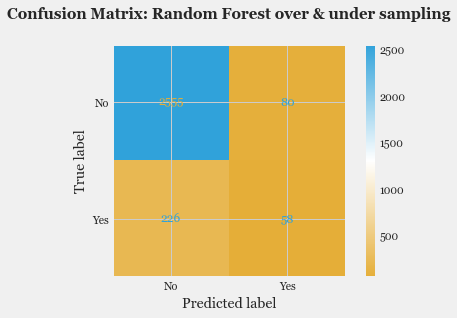

In [77]:
pred_rf3 = pipe_rf3.predict(X_test)

ac = accuracy_score(y_test, pred_rf3)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(y_test, pred_rf3))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe_rf3, X_test, y_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Random Forest over & under sampling', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [78]:
index += ["Random Forest over & under sampling: Test"]
scores["Accuracy"].append(round(accuracy_score(y_test, pred_rf3), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic Regression: Train,0.902
Imbalanced Logistic Regression: Test,0.902
Logistic Regression balanced class weights: Train,0.628
Logistic Regression balanced class weights: Test,0.634
Imbalanced Random Forest: Train,0.905
Imbalanced Random Forest: Test,0.905
Random Forest balanced class weight: Train,0.906
Random Forest balanced class weight_Test,0.908
Random Forest random undersampling: Train,0.648
Random Forest random undersampling: Test,0.669


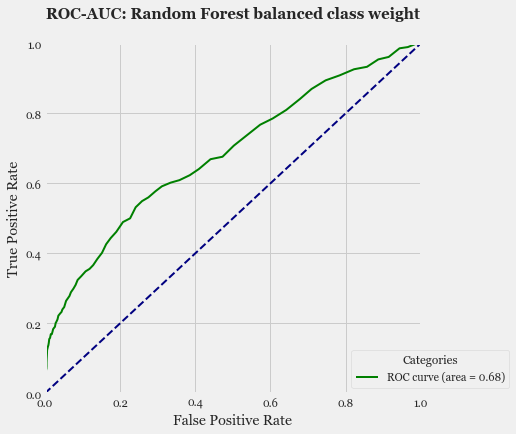

In [79]:
pred_prob_rf3 = pipe_rf3.predict_proba(X_test)[:,1]

fpr_rf3, tpr_rf3, _ = metrics.roc_curve(y_test, pred_prob_rf3)
roc_auc_rf3 = metrics.auc(fpr_rf3, tpr_rf3)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr_rf3, tpr_rf3, color='green', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc_rf3)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Random Forest balanced class weight', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

In [147]:
feat = [c for c in data.columns if c != 'Status']
fea_imp1 = pd.DataFrame(list(zip(feat, pipe_rf3[1].feature_importances_)), columns=['importance', 'values'])
best1 = fea_imp1.sort_values(by='values', ascending=False)
best1

,importance,values
6,forecast_meter_rent_12m,0.095137
0,cons_12m,0.080046
14,nb_prod_act,0.065359
3,forecast_cons_12m,0.061130
12,margin_gross_pow_ele,0.061015
16,num_years_antig,0.052111
2,cons_last_month,0.049974
11,imp_cons,0.042479
44,mean_3m_price_p3,0.041328
17,pow_max,0.035250


---

## 6. Model Building with trimmed dataset

<div class="alert alert-block alert-info">
    <b>
        <li>Since the previous models had very poor recall rates, the dataset was trimmed by 1% on both end. This would take care of some of the 0 values on the lower end as well as some of the very extreme outliers.</li>
        <li>Logistic Regression and Random Forest models and its variants were again used on this new dataset to predict churn.</li><br>
        <li>All the metrics drastically increased. This indicates that the 0 values in the dataset led to the underperformance of the metrics in the previous models.</li>
        <li>We will again be using the accuracy and recall metrics as our evaluation metrics.</li>
        <li>The fact that the prediction accuracies is about the same in both test and train data is a good sign that the models are working very well.</li>
        <li>The best model here is the Random Forest model with combined under and oversampling with the best accuracy as well as the best recall rate.</li>
        <li>Incidently, the imbalanced Logistic Regression and the imbalanced Random Forest also perform nearly as well. These could be very helpful for deployment in low resource environments.</li><br>
        
| Model | Train Accuracy | Test Accuracy | Recall | Precision | F1 score | ROC-AUC | 
| --- | --- | --- | --- | --- | --- | --- |
|Imbalanced Logistic Regression| 0.98 | 0.98 | 0.82 | 1.0 | 0.90 | 0.96 |
|Logistic Regression balanced class weights| 0.96 | 0.97 | 0.83 | 0.82 | 0.83 | 0.96 |
|Imbalanced Random Forest| 0.98 | 0.98 | 0.82 | 1.0 | 0.90 | 0.95 |
|Random Forest balanced class weight| 0.98 | 0.98 | 0.82 | 1.0 | 0.90 | 0.95 |
|Random Forest Random undersampling| 0.98 | 0.98 | 0.82 | 0.91 | 0.86 | 0.96 |
|Random Forest hybrid under and oversampling| 0.99 | 0.98 | 0.82 | 0.99 | 0.89 | 0.96 |
   </b>
</div>

In [81]:
data.head(3)

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power,SC_A,SC_B,SC_C,SC_D,SC_E,SC_F,SC_G,EC_A,EC_B,EC_C,EC_D,EC_E
0,14287.0,54946.0,2212.0,1149.83,1395.5,0.0,1.78,0.114481,0.098142,40.606701,0,159.96,25.44,25.44,2,678.99,3,43.648,0.124787,0.100749,0.06653,40.942265,22.35201,14.90134,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961,0.020393,3.538045,0.028554,3.538045,1,0,0,0,0,0,0,1,0,0,0,0
1,4660.0,0.0,2212.0,189.95,1395.5,0.0,16.27,0.145711,0.098837,44.311378,1,159.96,16.38,16.38,1,18.89,6,13.800,0.149609,0.007124,0.00000,44.311375,0.00000,0.00000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779,-0.003767,0.177780,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0
2,544.0,0.0,2212.0,47.96,1395.5,0.0,38.72,0.165794,0.087899,44.311378,1,159.96,28.60,28.60,1,6.60,6,13.856,0.170512,0.088421,0.00000,44.385450,0.00000,0.00000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779,-0.004628,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0


In [82]:
data.shape

(14592, 64)

In [83]:
# remove 1% of observations from top and bottom end
trim_data = pd.DataFrame(stats.trimboth(data, 0.01), columns=data.columns)

In [84]:
trim_data.head(3)

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power,SC_A,SC_B,SC_C,SC_D,SC_E,SC_F,SC_G,EC_A,EC_B,EC_C,EC_D,EC_E
0,301.0,0.0,45.0,16.89,28.0,0.0,2.42,0.097949,0.083816,40.606701,0.0,3.32,0.36,0.36,1.0,1.93,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685949,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682690,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681354,0.0,0.0,0.0,-0.014678,-0.000001,-0.013391,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,302.0,0.0,45.0,17.22,29.0,0.0,2.67,0.097949,0.083816,40.606701,0.0,3.32,0.36,0.36,1.0,1.98,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685949,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682690,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014628,-0.000001,-0.013391,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,303.0,0.0,46.0,17.35,29.0,0.0,2.68,0.098023,0.083816,40.606701,0.0,3.47,0.36,0.36,1.0,1.99,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.686089,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682692,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014591,-0.000001,-0.013384,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
trim_data.shape

(14302, 64)

In [86]:
trim_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14302 entries, 0 to 14301
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cons_12m                        14302 non-null  float64
 1   cons_gas_12m                    14302 non-null  float64
 2   cons_last_month                 14302 non-null  float64
 3   forecast_cons_12m               14302 non-null  float64
 4   forecast_cons_year              14302 non-null  float64
 5   forecast_discount_energy        14302 non-null  float64
 6   forecast_meter_rent_12m         14302 non-null  float64
 7   forecast_price_energy_off_peak  14302 non-null  float64
 8   forecast_price_energy_peak      14302 non-null  float64
 9   forecast_price_pow_off_peak     14302 non-null  float64
 10  has_gas                         14302 non-null  float64
 11  imp_cons                        14302 non-null  float64
 12  margin_gross_pow_ele            

In [87]:
trim_data.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14302.0,117887.732205,374898.437425,301.000000,5960.250000,14287.000000,39653.000000,3.329244e+06
cons_gas_12m,14302.0,14822.749126,75866.486879,0.000000,0.000000,0.000000,0.000000,8.889940e+05
cons_last_month,14302.0,12031.283037,40169.755100,45.000000,1430.250000,2212.000000,3295.250000,3.826470e+05
forecast_cons_12m,14302.0,1782.440181,1770.588171,16.890000,545.025000,1149.830000,2362.885000,9.268030e+03
forecast_cons_year,14302.0,1817.696965,1638.323400,28.000000,1155.250000,1395.500000,1696.000000,1.136500e+04
forecast_discount_energy,14302.0,0.682772,4.243891,0.000000,0.000000,0.000000,0.000000,3.000000e+01
forecast_meter_rent_12m,14302.0,61.428934,57.227832,2.420000,16.390000,19.430000,130.872500,3.287400e+02
forecast_price_energy_off_peak,14302.0,0.137388,0.019161,0.097949,0.116509,0.143166,0.146348,2.106890e-01
forecast_price_energy_peak,14302.0,0.097756,0.005001,0.083816,0.098837,0.098837,0.098837,1.305250e-01
forecast_price_pow_off_peak,14302.0,43.270615,2.325177,40.606701,40.606701,44.311378,44.311378,5.899595e+01


In [88]:
trim_data.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
cons_12m,5.012429,28.015647
cons_gas_12m,7.734795,68.318709
cons_last_month,5.733556,37.455930
forecast_cons_12m,1.715769,2.761905
forecast_cons_year,2.527512,7.464551
forecast_discount_energy,6.135669,36.112860
forecast_meter_rent_12m,0.627286,-1.234455
forecast_price_energy_off_peak,0.291295,-0.336356
forecast_price_energy_peak,-0.067961,7.754446
forecast_price_pow_off_peak,1.514147,9.747674


In [89]:
# Create train and test data
X1 = trim_data.drop('Status', axis=1)
y1 = trim_data['Status']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state= 40, stratify= y1)

In [90]:
Counter(y1)

Counter({0.0: 13028, 1.0: 1274})

In [91]:
# Dividing features
num_feat = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 
            'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
            'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
            'forecast_price_energy_peak', 'forecast_price_pow_off_peak',
            'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
            'net_margin', 'num_years_antig', 'pow_max',
            'mean_year_price_p1_var', 'mean_year_price_p2_var',
            'mean_year_price_p3_var', 'mean_year_price_p1_fix',
            'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
            'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3',
            'mean_6m_price_p1_var', 'mean_6m_price_p2_var', 'mean_6m_price_p3_var',
            'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix', 'mean_6m_price_p3_fix',
            'mean_6m_price_p1', 'mean_6m_price_p2', 'mean_6m_price_p3',
            'mean_3m_price_p1_var', 'mean_3m_price_p2_var', 'mean_3m_price_p3_var',
            'mean_3m_price_p1_fix', 'mean_3m_price_p2_fix', 'mean_3m_price_p3_fix',
            'mean_3m_price_p1', 'mean_3m_price_p2', 'mean_3m_price_p3', 
            'offpeak_diff_first_last_energy', 'offpeak_diff_first_last_power',
            'offpeak_diff_6m_last_energy', 'offpeak_diff_6m_last_power',
            'offpeak_diff_3m_last_energy', 'offpeak_diff_3m_last_power']

### A. Base Model Logistic Regression on imbalanced data

In [92]:
index = []
scores = {"Accuracy": []}

In [93]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model1 = LogisticRegression(max_iter=1000, random_state=42)

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe1 = Pipeline(steps=[("preprocessor", preprocessor), ("model", model1)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe1.fit(X1_train, y1_train)
score1 = cross_val_score(pipe1, X1_train, y1_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Imbalanced Logistic regression: Train"]
scores["Accuracy"].append(round(score1.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984


Accuracy: 0.98
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2606
         1.0       1.00      0.82      0.90       255

    accuracy                           0.98      2861
   macro avg       0.99      0.91      0.94      2861
weighted avg       0.98      0.98      0.98      2861



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


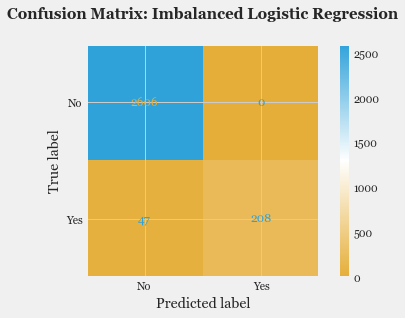

In [94]:
pred1 = pipe1.predict(X1_test)

ac = accuracy_score(y1_test, pred1)
print(f'Accuracy: {ac:.2f}')

print(classification_report(y1_test, pred1))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe1, X1_test, y1_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Imbalanced Logistic Regression', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [95]:
index += ["Imbalanced Logistic Regression: Test"]
scores["Accuracy"].append(round(accuracy_score(y1_test, pred1), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984


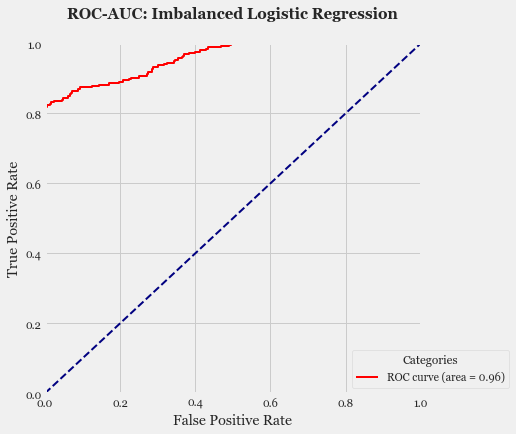

In [96]:
pred_prob1 = pipe1.predict_proba(X1_test)[:,1]

fpr1, tpr1, _ = metrics.roc_curve(y1_test, pred_prob1)
roc_auc1 = metrics.auc(fpr1, tpr1)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr1, tpr1, color='red', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Imbalanced Logistic Regression', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

### B. Logistic regression with balanced class weights

In [97]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model2 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe2 = Pipeline(steps=[("preprocessor", preprocessor), ("model", model2)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe2.fit(X1_train, y1_train)
score2 = cross_val_score(pipe2, X1_train, y1_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Logistic Regression balanced class weights: Train"]
scores["Accuracy"].append(round(score2.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984
Logistic Regression balanced class weights: Train,0.964


Accuracy_test: 0.97
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2606
         1.0       0.82      0.83      0.83       255

    accuracy                           0.97      2861
   macro avg       0.90      0.91      0.91      2861
weighted avg       0.97      0.97      0.97      2861



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


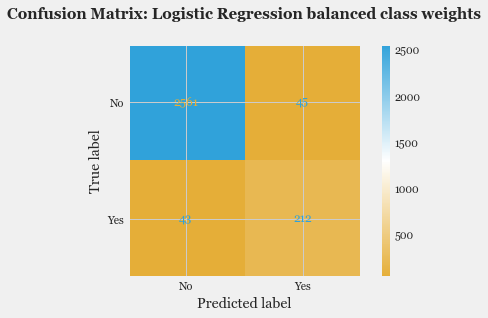

In [98]:
pred2 = pipe2.predict(X1_test)

ac = accuracy_score(y1_test, pred2)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(y1_test, pred2))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe2, X1_test, y1_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Logistic Regression balanced class weights', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [99]:
index += ["Logistic Regression balanced class weights: Test"]
scores["Accuracy"].append(round(accuracy_score(y1_test, pred2), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984
Logistic Regression balanced class weights: Train,0.964
Logistic Regression balanced class weights: Test,0.969


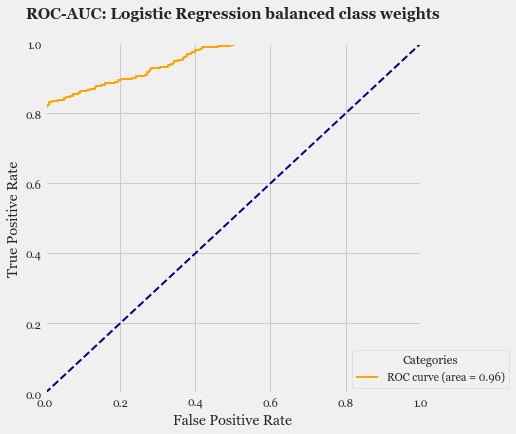

In [100]:
pred_prob2 = pipe2.predict_proba(X1_test)[:,1]

fpr2, tpr2, _ = metrics.roc_curve(y1_test, pred_prob2)
roc_auc2 = metrics.auc(fpr2, tpr2)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr2, tpr2, color='orange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Logistic Regression balanced class weights', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

### C. Imbalanced Random Forest

In [101]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model3 = RandomForestClassifier(max_features=None, random_state=42, n_jobs=2)

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe3 = Pipeline(steps=[("preprocessor", preprocessor), ("model", model3)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe3.fit(X1_train, y1_train)
score3 = cross_val_score(pipe3, X1_train, y1_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Imbalanced Random Forest: Train"]
scores["Accuracy"].append(round(score3.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984
Logistic Regression balanced class weights: Train,0.964
Logistic Regression balanced class weights: Test,0.969
Imbalanced Random Forest: Train,0.984


Accuracy_test: 0.98
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2606
         1.0       1.00      0.82      0.90       255

    accuracy                           0.98      2861
   macro avg       0.99      0.91      0.94      2861
weighted avg       0.98      0.98      0.98      2861



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


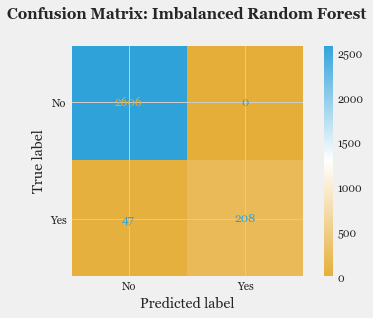

In [102]:
pred3 = pipe3.predict(X1_test)

ac = accuracy_score(y1_test, pred3)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(y1_test, pred3))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe3, X1_test, y1_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Imbalanced Random Forest', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [103]:
index += ["Imbalanced Random Forest: Test"]
scores["Accuracy"].append(round(accuracy_score(y1_test, pred3), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984
Logistic Regression balanced class weights: Train,0.964
Logistic Regression balanced class weights: Test,0.969
Imbalanced Random Forest: Train,0.984
Imbalanced Random Forest: Test,0.984


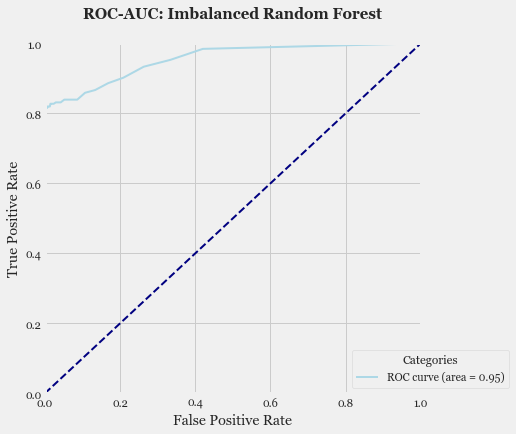

In [104]:
pred_prob3 = pipe3.predict_proba(X1_test)[:,1]

fpr3, tpr3, _ = metrics.roc_curve(y1_test, pred_prob3)
roc_auc3 = metrics.auc(fpr3, tpr3)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr3, tpr3, color='lightblue', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Imbalanced Random Forest', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

### D. Random Forest with balanced class weight

In [105]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model4 = RandomForestClassifier(max_features=None, random_state=42, n_jobs=2, class_weight='balanced')

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe4 = Pipeline(steps=[("preprocessor", preprocessor), ("model", model4)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe4.fit(X1_train, y1_train)
score4 = cross_val_score(pipe4, X1_train, y1_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Random Forest balanced class weight: Train"]
scores["Accuracy"].append(round(score4.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984
Logistic Regression balanced class weights: Train,0.964
Logistic Regression balanced class weights: Test,0.969
Imbalanced Random Forest: Train,0.984
Imbalanced Random Forest: Test,0.984
Random Forest balanced class weight: Train,0.984


Accuracy_test: 0.98
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2606
         1.0       1.00      0.82      0.90       255

    accuracy                           0.98      2861
   macro avg       0.99      0.91      0.94      2861
weighted avg       0.98      0.98      0.98      2861



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


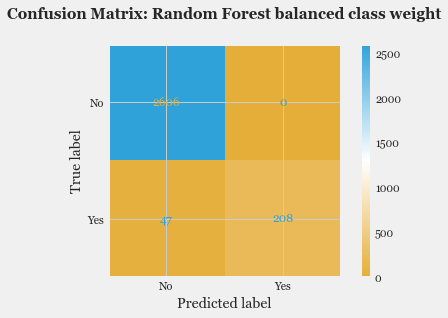

In [106]:
pred4 = pipe4.predict(X1_test)

ac = accuracy_score(y1_test, pred4)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(y1_test, pred4))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe4, X1_test, y1_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Random Forest balanced class weight', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [107]:
index += ["Random Forest balanced class weight: Test"]
scores["Accuracy"].append(round(accuracy_score(y1_test, pred4), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984
Logistic Regression balanced class weights: Train,0.964
Logistic Regression balanced class weights: Test,0.969
Imbalanced Random Forest: Train,0.984
Imbalanced Random Forest: Test,0.984
Random Forest balanced class weight: Train,0.984
Random Forest balanced class weight: Test,0.984


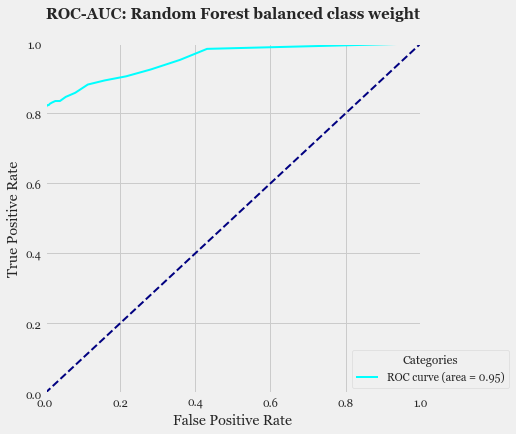

In [108]:
pred_prob4 = pipe4.predict_proba(X1_test)[:,1]

fpr4, tpr4, _ = metrics.roc_curve(y1_test, pred_prob4)
roc_auc4 = metrics.auc(fpr4, tpr4)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr4, tpr4, color='cyan', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Random Forest balanced class weight', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

### E. Random Forest with Random undersampling

In [109]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model5 = BalancedRandomForestClassifier(max_features=None, random_state=42, n_jobs=2)

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe5 = Pipeline(steps=[("preprocessor", preprocessor), ("model", model5)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe5.fit(X1_train, y1_train)
score5 = cross_val_score(pipe5, X1_train, y1_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Random Forest randon undersampling: Train"]
scores["Accuracy"].append(round(score5.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984
Logistic Regression balanced class weights: Train,0.964
Logistic Regression balanced class weights: Test,0.969
Imbalanced Random Forest: Train,0.984
Imbalanced Random Forest: Test,0.984
Random Forest balanced class weight: Train,0.984
Random Forest balanced class weight: Test,0.984
Random Forest randon undersampling: Train,0.975


Accuracy_test: 0.98
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2606
         1.0       0.91      0.82      0.86       255

    accuracy                           0.98      2861
   macro avg       0.94      0.91      0.92      2861
weighted avg       0.98      0.98      0.98      2861



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


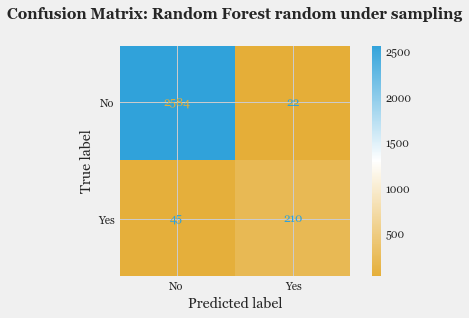

In [110]:
pred5 = pipe5.predict(X1_test)

ac = accuracy_score(y1_test, pred5)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(y1_test, pred5))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe5, X1_test, y1_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Random Forest random under sampling', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [111]:
index += ["Random Forest random undersampling: Test"]
scores["Accuracy"].append(round(accuracy_score(y1_test, pred5), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984
Logistic Regression balanced class weights: Train,0.964
Logistic Regression balanced class weights: Test,0.969
Imbalanced Random Forest: Train,0.984
Imbalanced Random Forest: Test,0.984
Random Forest balanced class weight: Train,0.984
Random Forest balanced class weight: Test,0.984
Random Forest randon undersampling: Train,0.975
Random Forest random undersampling: Test,0.977


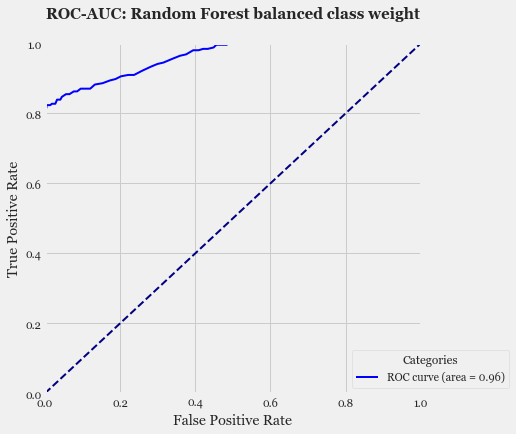

In [112]:
pred_prob5 = pipe5.predict_proba(X1_test)[:,1]

fpr5, tpr5, _ = metrics.roc_curve(y1_test, pred_prob5)
roc_auc5 = metrics.auc(fpr5, tpr5)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr5, tpr5, color='blue', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc5)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Random Forest balanced class weight', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

### F. Random Forest with under and oversampling

In [113]:
print(Counter(y1_train))

# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.3)
# fit and apply the transform
Xu, yu = over.fit_resample(X1_train, y1_train)
# summarize class distribution
print(Counter(yu))

# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
Xtrain_rs1, ytrain_rs1 = under.fit_resample(Xu, yu)
# summarize class distribution
print(Counter(ytrain_rs1))

Counter({0.0: 10422, 1.0: 1019})
Counter({0.0: 10422, 1.0: 3126})
Counter({0.0: 6252, 1.0: 3126})


In [114]:
# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model6 = RandomForestClassifier(max_features=None, random_state=42, n_jobs=2)

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe6 = Pipeline(steps=[("preprocessor", preprocessor), ("model", model6)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe6.fit(Xtrain_rs1, ytrain_rs1)
score6 = cross_val_score(pipe6, Xtrain_rs1, ytrain_rs1, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Random Forest over & under sampling: Train"]
scores["Accuracy"].append(round(score6.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984
Logistic Regression balanced class weights: Train,0.964
Logistic Regression balanced class weights: Test,0.969
Imbalanced Random Forest: Train,0.984
Imbalanced Random Forest: Test,0.984
Random Forest balanced class weight: Train,0.984
Random Forest balanced class weight: Test,0.984
Random Forest randon undersampling: Train,0.975
Random Forest random undersampling: Test,0.977


Accuracy_test: 0.98
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2606
         1.0       0.98      0.82      0.89       255

    accuracy                           0.98      2861
   macro avg       0.98      0.91      0.94      2861
weighted avg       0.98      0.98      0.98      2861



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


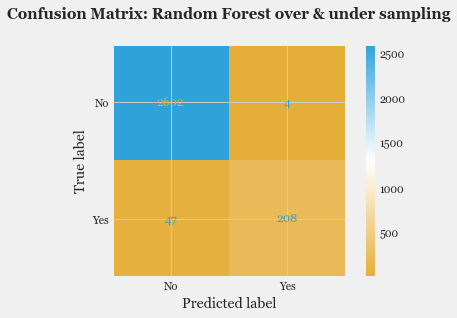

In [115]:
pred6 = pipe6.predict(X1_test)

ac = accuracy_score(y1_test, pred6)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(y1_test, pred6))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe6, X1_test, y1_test, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Random Forest over & under sampling', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [116]:
index += ["Random Forest over & under sampling: Test"]
scores["Accuracy"].append(round(accuracy_score(y1_test, pred6), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Imbalanced Logistic regression: Train,0.984
Imbalanced Logistic Regression: Test,0.984
Logistic Regression balanced class weights: Train,0.964
Logistic Regression balanced class weights: Test,0.969
Imbalanced Random Forest: Train,0.984
Imbalanced Random Forest: Test,0.984
Random Forest balanced class weight: Train,0.984
Random Forest balanced class weight: Test,0.984
Random Forest randon undersampling: Train,0.975
Random Forest random undersampling: Test,0.977


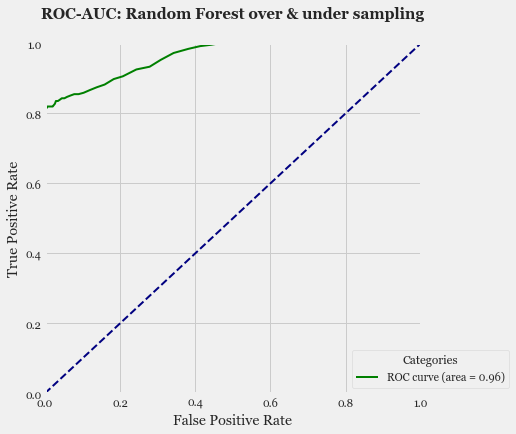

In [117]:
pred_prob6 = pipe6.predict_proba(X1_test)[:,1]

fpr6, tpr6, _ = metrics.roc_curve(y1_test, pred_prob6)
roc_auc6 = metrics.auc(fpr6, tpr6)

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr6, tpr6, color='green', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc6)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC: Random Forest over & under sampling', fontsize=15, fontweight='bold', pad=25)
plt.legend(title='Categories', bbox_to_anchor=(1.25, 0), loc= "lower right")
plt.show()

---

## 7. Probability to churn analysis

In [169]:
# Add probability to churn of the test dataset
trim_data['prob_churn'] = pipe6.predict_proba(trim_data[X1_test.columns])[:,1]
trim_data['churn_1'] = np.where(trim_data['prob_churn']>=0.14, 1, 0)
trim_data.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power,SC_A,SC_B,SC_C,SC_D,SC_E,SC_F,SC_G,EC_A,EC_B,EC_C,EC_D,EC_E,prob_churn,churn_1,revenue,revenue_churn,discount_revenue,revenue_delta,revenue_diff
0,301.0,0.0,45.0,16.89,28.0,0.0,2.42,0.097949,0.083816,40.606701,0.0,3.32,0.36,0.36,1.0,1.93,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685949,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682690,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681354,0.0,0.0,0.0,-0.014678,-0.000001,-0.013391,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.074359,4.074359,4.074359,0.0,0.0
1,302.0,0.0,45.0,17.22,29.0,0.0,2.67,0.097949,0.083816,40.606701,0.0,3.32,0.36,0.36,1.0,1.98,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685949,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682690,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014628,-0.000001,-0.013391,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.356682,4.356682,4.356682,0.0,0.0
2,303.0,0.0,46.0,17.35,29.0,0.0,2.68,0.098023,0.083816,40.606701,0.0,3.47,0.36,0.36,1.0,1.99,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.686089,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682692,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014591,-0.000001,-0.013384,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.380699,4.380699,4.380699,0.0,0.0
3,316.0,0.0,46.0,17.44,29.0,0.0,2.73,0.097949,0.083816,40.606701,0.0,3.40,0.36,0.36,1.0,2.14,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685960,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.683269,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014487,-0.000001,-0.013314,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.438231,4.438231,4.438231,0.0,0.0
4,308.0,0.0,47.0,18.25,29.0,0.0,3.49,0.098485,0.083816,40.606701,0.0,3.35,0.68,0.60,1.0,2.01,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685970,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.683269,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014039,-0.000001,-0.013259,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.287351,5.287351,5.287351,0.0,0.0


In [170]:
# Seperate high likely to churn customers from low likely to churn customers: cut0ff 50% mark
high_prob = trim_data[trim_data['prob_churn'] >= 0.50]
low_prob = trim_data[trim_data['prob_churn'] < 0.50]

In [171]:
print(trim_data.shape)
print(high_prob.shape)
print(low_prob.shape)

(14302, 71)
(1236, 71)
(13066, 71)


In [172]:
high_prob.prob_churn.describe()

count    1236.000000
mean        0.986133
std         0.056538
min         0.500000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: prob_churn, dtype: float64

In [173]:
low_prob.prob_churn.describe()

count    13066.000000
mean         0.031526
std          0.054455
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max          0.480000
Name: prob_churn, dtype: float64

In [174]:
features = [c for c in data.columns if c != 'Status']
fea_imp = pd.DataFrame(list(zip(features, pipe6[1].feature_importances_)), columns=['importance', 'values'])
best = fea_imp.sort_values(by='values', ascending=False)
best

,importance,values
4,forecast_cons_year,0.756972
7,forecast_price_energy_off_peak,0.024189
17,pow_max,0.013225
23,mean_year_price_p3_fix,0.012493
0,cons_12m,0.009986
6,forecast_meter_rent_12m,0.009826
32,mean_6m_price_p3_fix,0.009774
12,margin_gross_pow_ele,0.008014
3,forecast_cons_12m,0.007985
14,nb_prod_act,0.007403


In [175]:
# Provide 20% Discount on all price variables
df_disc = trim_data.drop(['prob_churn', 'churn_1'], axis=1)
df_disc['forecast_price_energy_off_peak'] = df_disc['forecast_price_energy_off_peak'].astype(float)/1.25
df_disc['forecast_price_energy_peak'] = df_disc['forecast_price_energy_peak'].astype(float)/1.25
df_disc['forecast_price_pow_off_peak'] = df_disc['forecast_price_pow_off_peak'].astype(float)/1.25

df_disc['mean_year_price_p1_var'] = df_disc['mean_year_price_p1_var'].astype(float)/1.25
df_disc['mean_year_price_p2_var'] = df_disc['mean_year_price_p2_var'].astype(float)/1.25
df_disc['mean_year_price_p3_var'] = df_disc['mean_year_price_p3_var'].astype(float)/1.25
df_disc['mean_year_price_p1_fix'] = df_disc['mean_year_price_p1_fix'].astype(float)/1.25
df_disc['mean_year_price_p2_fix'] = df_disc['mean_year_price_p2_fix'].astype(float)/1.25
df_disc['mean_year_price_p3_fix'] = df_disc['mean_year_price_p3_fix'].astype(float)/1.25
df_disc['mean_year_price_p1'] = df_disc['mean_year_price_p1'].astype(float)/1.25
df_disc['mean_year_price_p2'] = df_disc['mean_year_price_p2'].astype(float)/1.25
df_disc['mean_year_price_p3'] = df_disc['mean_year_price_p3'].astype(float)/1.25

df_disc['mean_6m_price_p1_var'] = df_disc['mean_6m_price_p1_var'].astype(float)/1.25
df_disc['mean_6m_price_p2_var'] = df_disc['mean_6m_price_p2_var'].astype(float)/1.25
df_disc['mean_6m_price_p3_var'] = df_disc['mean_6m_price_p3_var'].astype(float)/1.25
df_disc['mean_6m_price_p1_fix'] = df_disc['mean_6m_price_p1_fix'].astype(float)/1.25
df_disc['mean_6m_price_p2_fix'] = df_disc['mean_6m_price_p2_fix'].astype(float)/1.25
df_disc['mean_6m_price_p3_fix'] = df_disc['mean_6m_price_p3_fix'].astype(float)/1.25
df_disc['mean_6m_price_p1'] = df_disc['mean_6m_price_p1'].astype(float)/1.25
df_disc['mean_6m_price_p2'] = df_disc['mean_6m_price_p2'].astype(float)/1.25
df_disc['mean_6m_price_p3'] = df_disc['mean_6m_price_p3'].astype(float)/1.25

df_disc['mean_3m_price_p1_var'] = df_disc['mean_3m_price_p1_var'].astype(float)/1.25
df_disc['mean_3m_price_p2_var'] = df_disc['mean_3m_price_p2_var'].astype(float)/1.25
df_disc['mean_3m_price_p3_var'] = df_disc['mean_3m_price_p3_var'].astype(float)/1.25
df_disc['mean_3m_price_p1_fix'] = df_disc['mean_3m_price_p1_fix'].astype(float)/1.25
df_disc['mean_3m_price_p2_fix'] = df_disc['mean_3m_price_p2_fix'].astype(float)/1.25
df_disc['mean_3m_price_p3_fix'] = df_disc['mean_3m_price_p3_fix'].astype(float)/1.25
df_disc['mean_3m_price_p1'] = df_disc['mean_3m_price_p1'].astype(float)/1.25
df_disc['mean_3m_price_p2'] = df_disc['mean_3m_price_p2'].astype(float)/1.25
df_disc['mean_3m_price_p3'] = df_disc['mean_3m_price_p3'].astype(float)/1.25

df_disc['offpeak_diff_first_last_energy'] = df_disc['offpeak_diff_first_last_energy'].astype(float)/1.25
df_disc['offpeak_diff_first_last_power'] = df_disc['offpeak_diff_first_last_power'].astype(float)/1.25
df_disc['offpeak_diff_6m_last_energy'] = df_disc['offpeak_diff_6m_last_energy'].astype(float)/1.25
df_disc['offpeak_diff_6m_last_power'] = df_disc['offpeak_diff_6m_last_power'].astype(float)/1.25
df_disc['offpeak_diff_3m_last_energy'] = df_disc['offpeak_diff_3m_last_energy'].astype(float)/1.25
df_disc['offpeak_diff_3m_last_power'] = df_disc['offpeak_diff_3m_last_power'].astype(float)/1.25

df_disc.head(3)

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power,SC_A,SC_B,SC_C,SC_D,SC_E,SC_F,SC_G,EC_A,EC_B,EC_C,EC_D,EC_E,revenue,revenue_churn,discount_revenue,revenue_delta,revenue_diff
0,301.0,0.0,45.0,16.89,28.0,0.0,2.42,0.078359,0.067053,32.485361,0.0,3.32,0.36,0.36,1.0,1.93,3.0,10.35,0.083236,0.0,0.0,32.452777,0.0,0.0,32.548760,0.0,0.0,0.081304,0.0,0.0,32.452778,0.0,0.0,32.546152,0.0,0.0,0.080531,0.0,0.0,32.452778,0.0,0.0,32.545083,0.0,0.0,0.0,-0.011742,-9.600000e-07,-0.010713,0.0,-0.003693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.074359,4.074359,4.074359,0.0,0.0
1,302.0,0.0,45.0,17.22,29.0,0.0,2.67,0.078359,0.067053,32.485361,0.0,3.32,0.36,0.36,1.0,1.98,3.0,10.35,0.083236,0.0,0.0,32.452777,0.0,0.0,32.548760,0.0,0.0,0.081304,0.0,0.0,32.452778,0.0,0.0,32.546152,0.0,0.0,0.080531,0.0,0.0,32.452778,0.0,0.0,32.545085,0.0,0.0,0.0,-0.011702,-9.600000e-07,-0.010713,0.0,-0.003693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.356682,4.356682,4.356682,0.0,0.0
2,303.0,0.0,46.0,17.35,29.0,0.0,2.68,0.078418,0.067053,32.485361,0.0,3.47,0.36,0.36,1.0,1.99,3.0,10.35,0.083236,0.0,0.0,32.452777,0.0,0.0,32.548871,0.0,0.0,0.081304,0.0,0.0,32.452778,0.0,0.0,32.546154,0.0,0.0,0.080531,0.0,0.0,32.452778,0.0,0.0,32.545085,0.0,0.0,0.0,-0.011673,-9.600000e-07,-0.010707,0.0,-0.003693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.380699,4.380699,4.380699,0.0,0.0


In [176]:
# Create new model with discounted price
X_disc = df_disc.drop('Status', axis=1)
y_disc = df_disc['Status']

Xtrain_disc, Xtest_disc, ytrain_disc, ytest_disc = train_test_split(X_disc, y_disc, test_size=0.2, random_state= 42, stratify= y_disc)

In [177]:
print(Counter(y1_train))

# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.3)
# fit and apply the transform
Xros, yrus = over.fit_resample(Xtrain_disc, ytrain_disc)
# summarize class distribution
print(Counter(yrus))

# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
Xtrain_disc, ytrain_disc = under.fit_resample(Xros, yrus)
# summarize class distribution
print(Counter(ytrain_disc))

Counter({0.0: 10422, 1.0: 1019})
Counter({0.0: 10422, 1.0: 3126})
Counter({0.0: 6252, 1.0: 3126})


In [178]:
index = []
scores = {"Accuracy": []}

# Column transformers
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_feat)])

# Define Model
model_new = RandomForestClassifier(max_features=None, random_state=42, n_jobs=2)

# # Define transformer
# power = PowerTransformer(method='yeo-johnson')

# Define pipeline
pipe_new = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_new)])

# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

pipe_new.fit(Xtrain_disc, ytrain_disc)
score_new = cross_val_score(pipe_new, Xtrain_disc, ytrain_disc, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

index += ["Random Forest over & under sampling: Train discounted data"]
scores["Accuracy"].append(round(score_new.mean(), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Random Forest over & under sampling: Train discounted data,0.996


Accuracy_test: 0.98
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2606
         1.0       0.97      0.84      0.90       255

    accuracy                           0.98      2861
   macro avg       0.98      0.92      0.95      2861
weighted avg       0.98      0.98      0.98      2861



C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


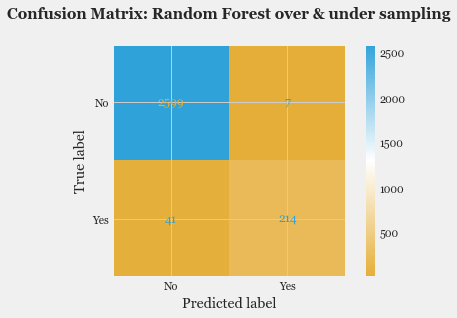

In [179]:
pred_new = pipe_new.predict(Xtest_disc)

ac = accuracy_score(ytest_disc, pred_new)
print(f'Accuracy_test: {ac:.2f}')

print(classification_report(ytest_disc, pred_new))

cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38','#ffffff','#30a2da'])
metrics.plot_confusion_matrix(pipe_new, Xtest_disc, ytest_disc, display_labels=['No', 'Yes'], cmap=cmap)
plt.title('Confusion Matrix: Random Forest over & under sampling', fontsize=15, fontweight='bold', pad=25)
plt.show()

In [180]:
index += ["Random Forest over & under sampling: Test"]
scores["Accuracy"].append(round(accuracy_score(ytest_disc, pred_new), 3))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy
Random Forest over & under sampling: Train discounted data,0.996
Random Forest over & under sampling: Test,0.983


In [181]:
# Add probability to churn to the dataset
df_disc['prob_churn'] = pipe_new.predict_proba(df_disc[Xtest_disc.columns])[:,1]
df_disc['churn_1'] = np.where(df_disc['prob_churn']>=0.14, 1, 0)
df_disc.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power,SC_A,SC_B,SC_C,SC_D,SC_E,SC_F,SC_G,EC_A,EC_B,EC_C,EC_D,EC_E,revenue,revenue_churn,discount_revenue,revenue_delta,revenue_diff,prob_churn,churn_1
0,301.0,0.0,45.0,16.89,28.0,0.0,2.42,0.078359,0.067053,32.485361,0.0,3.32,0.36,0.36,1.0,1.93,3.0,10.35,0.083236,0.0,0.0,32.452777,0.0,0.0,32.548760,0.0,0.0,0.081304,0.0,0.0,32.452778,0.0,0.0,32.546152,0.0,0.0,0.080531,0.0,0.0,32.452778,0.0,0.0,32.545083,0.0,0.0,0.0,-0.011742,-9.600000e-07,-0.010713,0.0,-0.003693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.074359,4.074359,4.074359,0.0,0.0,0.0,0
1,302.0,0.0,45.0,17.22,29.0,0.0,2.67,0.078359,0.067053,32.485361,0.0,3.32,0.36,0.36,1.0,1.98,3.0,10.35,0.083236,0.0,0.0,32.452777,0.0,0.0,32.548760,0.0,0.0,0.081304,0.0,0.0,32.452778,0.0,0.0,32.546152,0.0,0.0,0.080531,0.0,0.0,32.452778,0.0,0.0,32.545085,0.0,0.0,0.0,-0.011702,-9.600000e-07,-0.010713,0.0,-0.003693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.356682,4.356682,4.356682,0.0,0.0,0.0,0
2,303.0,0.0,46.0,17.35,29.0,0.0,2.68,0.078418,0.067053,32.485361,0.0,3.47,0.36,0.36,1.0,1.99,3.0,10.35,0.083236,0.0,0.0,32.452777,0.0,0.0,32.548871,0.0,0.0,0.081304,0.0,0.0,32.452778,0.0,0.0,32.546154,0.0,0.0,0.080531,0.0,0.0,32.452778,0.0,0.0,32.545085,0.0,0.0,0.0,-0.011673,-9.600000e-07,-0.010707,0.0,-0.003693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.380699,4.380699,4.380699,0.0,0.0,0.0,0
3,316.0,0.0,46.0,17.44,29.0,0.0,2.73,0.078359,0.067053,32.485361,0.0,3.40,0.36,0.36,1.0,2.14,3.0,10.35,0.083236,0.0,0.0,32.452777,0.0,0.0,32.548768,0.0,0.0,0.081304,0.0,0.0,32.452778,0.0,0.0,32.546615,0.0,0.0,0.080531,0.0,0.0,32.452778,0.0,0.0,32.545085,0.0,0.0,0.0,-0.011590,-9.600000e-07,-0.010651,0.0,-0.003693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.438231,4.438231,4.438231,0.0,0.0,0.0,0
4,308.0,0.0,47.0,18.25,29.0,0.0,3.49,0.078788,0.067053,32.485361,0.0,3.35,0.68,0.60,1.0,2.01,3.0,10.35,0.083236,0.0,0.0,32.452777,0.0,0.0,32.548776,0.0,0.0,0.081304,0.0,0.0,32.452778,0.0,0.0,32.546615,0.0,0.0,0.080531,0.0,0.0,32.452778,0.0,0.0,32.545085,0.0,0.0,0.0,-0.011231,-9.600000e-07,-0.010607,0.0,-0.003693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.287351,5.287351,5.287351,0.0,0.0,0.0,0


In [182]:
df_disc.prob_churn.describe()

count    14302.000000
mean         0.116011
std          0.274690
min          0.000000
25%          0.000000
50%          0.000000
75%          0.070000
max          1.000000
Name: prob_churn, dtype: float64

In [183]:
trim_data.prob_churn.describe()

count    14302.000000
mean         0.114025
std          0.273748
min          0.000000
25%          0.000000
50%          0.000000
75%          0.070000
max          1.000000
Name: prob_churn, dtype: float64

In [184]:
# Seperate high likely to churn customers from low likely to churn customers: cut0ff 50% mark
high_prob_new = df_disc[df_disc['prob_churn'] >= 0.50]
low_prob_new = df_disc[df_disc['prob_churn'] < 0.50]

In [185]:
high_prob_new.prob_churn.describe()

count    1250.000000
mean        0.982776
std         0.065415
min         0.500000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: prob_churn, dtype: float64

---

## 8. Business Impact

In [162]:
# we will offer the discount to customers with 50% or higher probability of churning.
trim_data.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power,SC_A,SC_B,SC_C,SC_D,SC_E,SC_F,SC_G,EC_A,EC_B,EC_C,EC_D,EC_E,prob_churn,churn_1,revenue,revenue_churn,discount_revenue,revenue_delta
0,301.0,0.0,45.0,16.89,28.0,0.0,2.42,0.097949,0.083816,40.606701,0.0,3.32,0.36,0.36,1.0,1.93,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685949,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682690,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681354,0.0,0.0,0.0,-0.014678,-0.000001,-0.013391,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.074359,4.074359,4.074359,0.0
1,302.0,0.0,45.0,17.22,29.0,0.0,2.67,0.097949,0.083816,40.606701,0.0,3.32,0.36,0.36,1.0,1.98,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685949,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682690,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014628,-0.000001,-0.013391,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.356682,4.356682,4.356682,0.0
2,303.0,0.0,46.0,17.35,29.0,0.0,2.68,0.098023,0.083816,40.606701,0.0,3.47,0.36,0.36,1.0,1.99,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.686089,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682692,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014591,-0.000001,-0.013384,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.380699,4.380699,4.380699,0.0
3,316.0,0.0,46.0,17.44,29.0,0.0,2.73,0.097949,0.083816,40.606701,0.0,3.40,0.36,0.36,1.0,2.14,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685960,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.683269,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014487,-0.000001,-0.013314,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.438231,4.438231,4.438231,0.0
4,308.0,0.0,47.0,18.25,29.0,0.0,3.49,0.098485,0.083816,40.606701,0.0,3.35,0.68,0.60,1.0,2.01,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685970,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.683269,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014039,-0.000001,-0.013259,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.287351,5.287351,5.287351,0.0


In [163]:
# create revenue variable
trim_data['revenue'] = trim_data['forecast_cons_12m'] * trim_data['forecast_price_energy_off_peak'] + trim_data['forecast_meter_rent_12m']
trim_data['revenue_churn'] = trim_data['revenue']* (1 - 0.919 * trim_data['Status'])
trim_data.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,Status,offpeak_diff_first_last_energy,offpeak_diff_first_last_power,offpeak_diff_6m_last_energy,offpeak_diff_6m_last_power,offpeak_diff_3m_last_energy,offpeak_diff_3m_last_power,SC_A,SC_B,SC_C,SC_D,SC_E,SC_F,SC_G,EC_A,EC_B,EC_C,EC_D,EC_E,prob_churn,churn_1,revenue,revenue_churn,discount_revenue,revenue_delta
0,301.0,0.0,45.0,16.89,28.0,0.0,2.42,0.097949,0.083816,40.606701,0.0,3.32,0.36,0.36,1.0,1.93,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685949,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682690,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681354,0.0,0.0,0.0,-0.014678,-0.000001,-0.013391,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.074359,4.074359,4.074359,0.0
1,302.0,0.0,45.0,17.22,29.0,0.0,2.67,0.097949,0.083816,40.606701,0.0,3.32,0.36,0.36,1.0,1.98,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685949,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682690,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014628,-0.000001,-0.013391,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.356682,4.356682,4.356682,0.0
2,303.0,0.0,46.0,17.35,29.0,0.0,2.68,0.098023,0.083816,40.606701,0.0,3.47,0.36,0.36,1.0,1.99,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.686089,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.682692,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014591,-0.000001,-0.013384,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.380699,4.380699,4.380699,0.0
3,316.0,0.0,46.0,17.44,29.0,0.0,2.73,0.097949,0.083816,40.606701,0.0,3.40,0.36,0.36,1.0,2.14,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685960,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.683269,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014487,-0.000001,-0.013314,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.438231,4.438231,4.438231,0.0
4,308.0,0.0,47.0,18.25,29.0,0.0,3.49,0.098485,0.083816,40.606701,0.0,3.35,0.68,0.60,1.0,2.01,3.0,10.35,0.104044,0.0,0.0,40.565971,0.0,0.0,40.685970,0.0,0.0,0.10163,0.0,0.0,40.565973,0.0,0.0,40.683269,0.0,0.0,0.100664,0.0,0.0,40.565973,0.0,0.0,40.681356,0.0,0.0,0.0,-0.014039,-0.000001,-0.013259,0.0,-0.004616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.287351,5.287351,5.287351,0.0


In [164]:
print(f'Estimated forecasted revenue without discount: €{trim_data.revenue_churn.sum():.2f}')

Estimated forecasted revenue without discount: €3441029.71


In [168]:
# calculating estimated revenue with intervention
# assume customers stay for the full year and do not churn irrespective of actual churn outcome
# subset dataframe for probability to churn > 0.5 and have revenue > 500
trim_data['discount_revenue'] = trim_data['revenue_churn']
trim_data.loc[(trim_data['prob_churn'] >= 0.5) & (trim_data['revenue'] > 500),'discount_revenue'] = trim_data['revenue'] * 0.8
trim_data['revenue_diff'] = trim_data['discount_revenue'] - trim_data['revenue_churn']

print(f'Estimated forecasted revenue without discount: €{trim_data.revenue_churn.sum():.2f}')
print(f'Estimated forecasted revenue with discount for high probability to churn customers: €{trim_data.discount_revenue.sum():.2f}')
print(f'Estimated difference in forecasted revenue with intervention: €{trim_data.revenue_diff.sum():.2f}')
print(f'Estimated revenue increase percentage: {trim_data.revenue_diff.sum()/trim_data.revenue_churn.sum()*100:.2f}%')

Estimated forecasted revenue without discount: €3441029.71
Estimated forecasted revenue with discount for high probability to churn customers: €4423850.77
Estimated difference in forecasted revenue with intervention: €982821.05
Estimated revenue increase percentage: 28.56%
